# **Investigating Causes and Impacts of Air Pollution in Poland**
### Objective 1: Analyze the relative importance of different sources of air pollution in Poland in 2019


1) Acquire data of the same time  

2) Assemble a dataset with relevant features, including air quality data and potential contributing factors such as traffic, industrial, power plant. 

3) Handle missing data, outliers, and ensure that the dataset is properly formatted for Random Forest analysis. Encode categorical variables and standardize/normalize numerical variables. 

4) Divide the dataset into training and testing sets. The training set will be used to train the Random Forest model, and the testing set will be used to evaluate its performance. 

5) Use a Random Forest regression model, train the model using training dataset 

6) Assess the performance of the model suing the testing dataset 

7) Extract feature importance scores from the trained Random Forest model 

8) Create a visualization to display the feature importance scores 

9) Analyze the feature importance results to identify which variables have the most significant impact on air quality in Poland in 2019 in each province. 

**Importing libraries:**

In [207]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
#%matplotlib inline
from shapely.geometry import Point

We found three useful datasets for this objective:
1) **Provinces**: contains shapefile with large administrative boundaries that will be used as a base dataframe and will receive information from the other datasets.
2) **Traffic**: contains emissions (in tonnes) of pollutants (CH4, NOx, N2O, NMVOC) per provinces. 
3) **Industrial**: contains emissions (in kg) of pollutants (CH4, NOx, N2O, NMVOC) in facility level from diverse sectors (energy, waste management, metal production, etc.)

**Reading files:** 
1) Provinces of Poland (shapefile)

In [77]:
provinces = gpd.read_file("data/wojewodztwa/wojewodztwa.shp")

In [78]:
provinces.head(2)

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,WOJ,2289315,32,zachodniopomorskie,None,0,20220613,0,20120926,...,1364544,0,None,0,0,12.1323542862,3.10794349875,81168387600000,wojewodztwo,"POLYGON ((188256.168 683730.875, 189761.898 68..."
1,None,WOJ,1398751,08,lubuskie,None,0,20211210,0,20120926,...,1361674,0,None,0,0,11.0914310011,1.83850176383,97789593100000,wojewodztwo,"POLYGON ((249058.528 411232.826, 249030.522 41..."


In [79]:
provinces.crs

<Projected CRS: EPSG:2180>
Name: ETRF2000-PL / CS92
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore.
- bounds: (14.14, 49.0, 24.15, 55.93)
Coordinate Operation:
- name: Poland CS92
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [80]:
print(provinces.crs)

EPSG:2180


Reprojecting CRS from **EPSG:2180** to **EPSG:4326**:

In [81]:
provinces  = provinces.to_crs({'init': 'epsg:4326'})

C:\Users\hudso\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [82]:
print(provinces.crs)

+init=epsg:4326 +type=crs


Filtering relevant information and renaming the column names:

In [83]:
provinces = provinces[["JPT_NAZWA_", "SHAPE_AREA", "geometry"]]

In [84]:
provinces.columns = ["NAME", "AREA", "geometry"]

In [85]:
provinces.head(2)

,NAME,AREA,geometry
0,zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417..."
1,lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153..."


---

**Reading files:** \
2) Traffic (csv)

In [365]:
traffic_ch4 = pd.read_csv("data/traffic_province/2019_CH4.csv")
traffic_n2o = pd.read_csv("data/traffic_province/2019_N2O.csv")
traffic_nmvoc = pd.read_csv("data/traffic_province/2019_NMVOC.csv")
traffic_nox = pd.read_csv("data/traffic_province/2019_NOx.csv")

The emissions of all data will be compared in terms of "tonnes":

In [366]:
traffic_ch4["Total_kg"] = traffic_ch4["Total_tonnes"] * 1000
traffic_n2o["Total_kg"] = traffic_n2o["Total_tonnes"] * 1000
traffic_nmvoc["Total_kg"] = traffic_nmvoc["Total_tonnes"] * 1000
traffic_nox["Total_kg"] = traffic_nox["Total_tonnes"] * 1000

The datasets contain province names written in different ways: using the Polish alphabet or Latin alphabet. Some datasets include also behind the names the word "voivodship", which means "province" in English. It is necessary to standardize the province's names to the written in exactly the same way in every dataset. Here we make a dictionary to convert the original names to the standardized ones:

In [368]:
province_names_list = []

for i in range(len(traffic_ch4)):
    
    name = traffic_ch4["Voivodship"][i].split(" ")[0]
    province_names_list.append(name)    

In [369]:
#provinces2 = provinces.copy()

In [370]:
# dictionaries:

dic_traffic_to_standard = dict(zip(province_names_list, 
                          traffic_ch4["Voivodship"].copy()))

dic_provinces_to_standard = dict(zip(province_names_list, 
                          provinces["NAME"].reindex(index = [4, 15, 5, 7, 12, 9, 13, 10, 14, 1, 3, 6, 11, 2, 8, 0]))).copy()

In [371]:
def standard_names_for_provinces(dictionary, df_to_be_changed, name_column):
    for i,j in dictionary.items():
        idx = df_to_be_changed[df_to_be_changed[name_column]==j].index
        df_to_be_changed.loc[idx, name_column]=i
    return df_to_be_changed

In [372]:
traffic_ch4 = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_ch4, name_column = "Voivodship")
traffic_n2o = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_n2o, name_column = "Voivodship")
traffic_nmvoc = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_nmvoc, name_column = "Voivodship")
traffic_nox = standard_names_for_provinces(dictionary = dic_traffic_to_standard, df_to_be_changed = traffic_nox, name_column = "Voivodship")
provinces = standard_names_for_provinces(dictionary = dic_provinces_to_standard, df_to_be_changed = provinces, name_column = "NAME")

---

**Reading files:** \
3) Industrial dataset (csv)

In [54]:
industry = pd.read_csv("data/industrial/F1_4_Detailed releases at facility level with E-PRTR Sector and Annex I Activity detail into Air.csv")

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\2717583939.py:1: DtypeWarning: Columns (7,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  industry = pd.read_csv("data/industrial/F1_4_Detailed releases at facility level with E-PRTR Sector and Annex I Activity detail into Air.csv")


Filtering the data for **"Poland"** in **"2019"**:

In [55]:
industry_pl2019 = industry[(industry["countryName"]=="Poland") & (industry["reportingYear"]==2019)].reset_index(drop=True)

Converting it to a geopandas dataframe, with crs = EPSG:4326:

In [56]:
industry_pl2019gpd = gpd.GeoDataFrame(
    industry_pl2019, geometry=gpd.points_from_xy(industry_pl2019.Longitude, industry_pl2019.Latitude), crs="EPSG:4326")

In [57]:
industry_pl2019gpd.head(2)

,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry
0,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000004.FACILITY,Ciepłownia Miejska,NaN,20.448046,52.068836,NaN,Żyrardów,AIR,Sulphur oxides (SOX),163000.0,2019,NaN,POINT (20.44805 52.06884)
1,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000005.FACILITY,Zakład Z-2 Knurów,NaN,18.678440,50.215218,NaN,Knurów,AIR,Sulphur oxides (SOX),152000.0,2019,NaN,POINT (18.67844 50.21522)


Plotting the provinces and industries (color: sector names):

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\4051566792.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  provinces["CENTER"] = provinces["geometry"].centroid


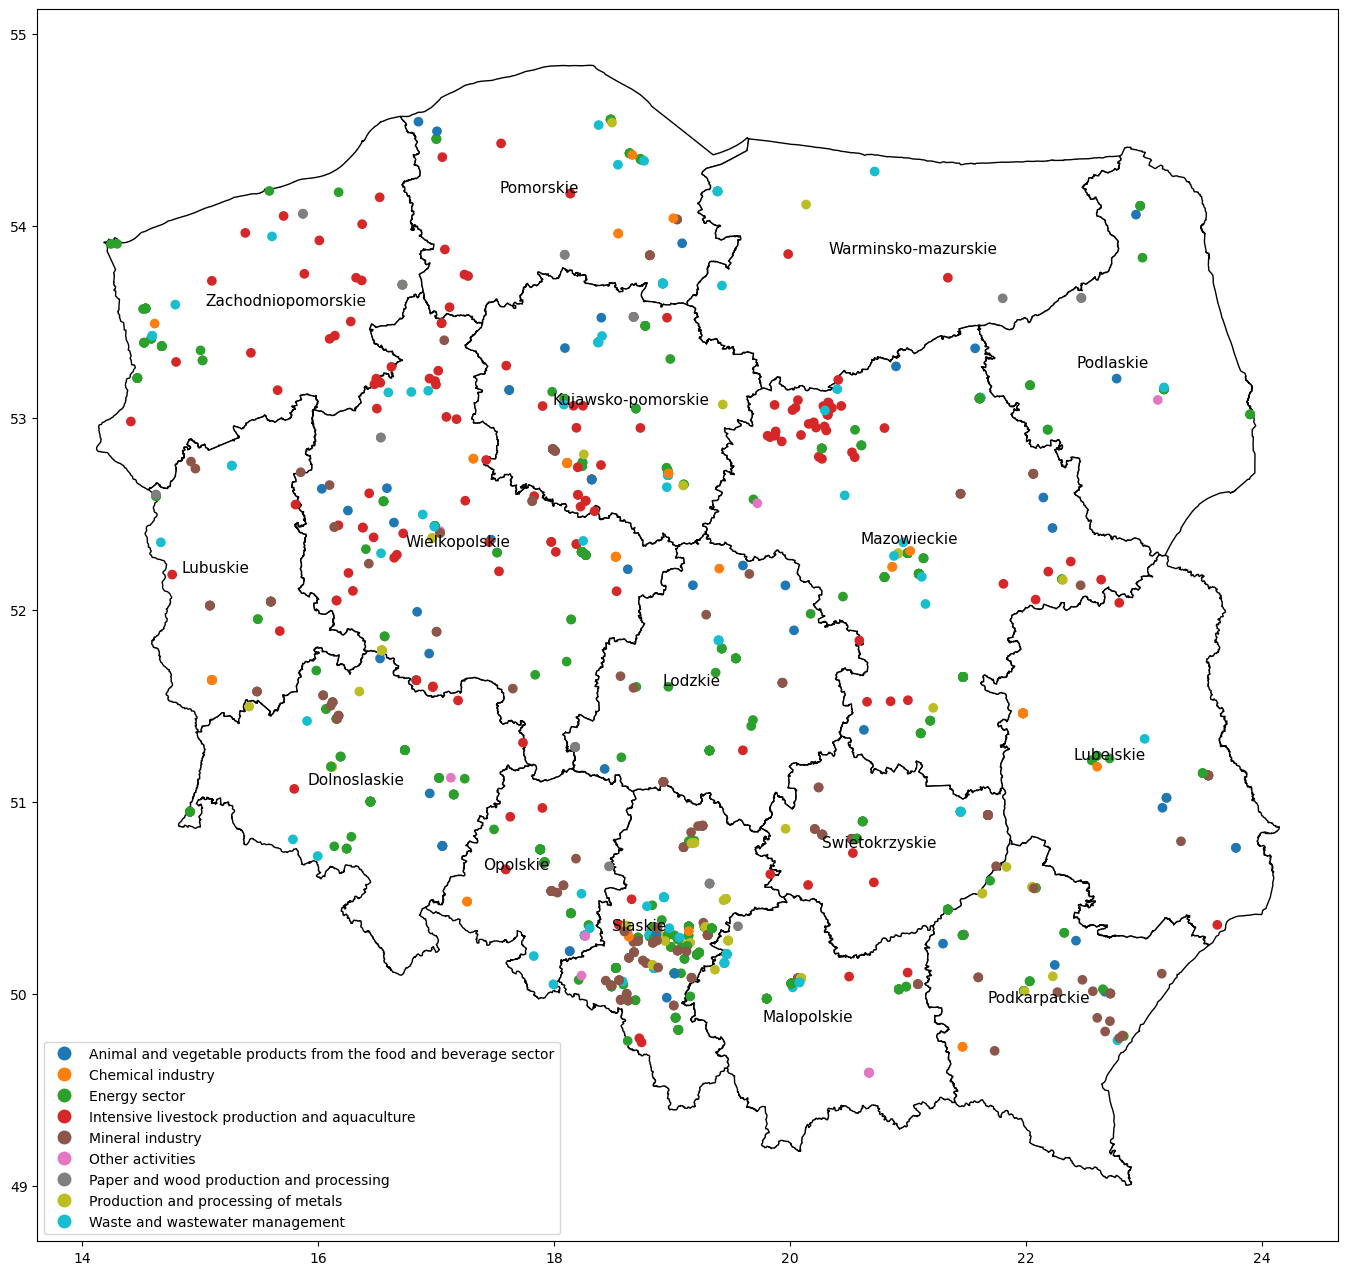

Text(0.5, 1.0, 'Provinces of Poland')

In [93]:
p = provinces.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
provinces["CENTER"] = provinces["geometry"].centroid
provinces_points = provinces.copy()
provinces_points.set_geometry(provinces["CENTER"], inplace = True)
texts = []

for x, y, label in zip(provinces_points.geometry.x, provinces_points.geometry.y, provinces_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
industry_pl2019gpd.plot(column='eprtrSectorName', ax=p, figsize = (20,16), legend=True)
plt.show()

p.axis('off')
p.set_title('Provinces of Poland')


Now we want relate each of those points (industries) to the province where they are within. \
First, we will reset the indexes to create a new column of indexes. Then it is easier to use this column to connect both datasets:

In [267]:
ind = industry_pl2019gpd.copy()
ind = ind.reset_index()

In [268]:
len(provinces)

16

In [269]:
ind["PROVINCE"]=""

for i in range(len(provinces)):
    df = gpd.overlay(ind, provinces[provinces["NAME"]==provinces["NAME"][i]], how='intersection')
    ind.loc[df["index"],"PROVINCE"]=provinces["NAME"][i]
    #print(i, "-", provinces["NAME"][i])
    

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\1487002112.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  df = gpd.overlay(ind, provinces[provinces["NAME"]==provinces["NAME"][i]], how='intersection')
C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\1487002112.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  df = gpd.overlay(ind, provinces[provinces["NAME"]==provinces["NAME"][i]], how='intersection')
C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\1487002112.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of t

Now, it is better check if everything worked well. Let's plot all the points with color according to the province where they are associated to:

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\116429968.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  provinces["CENTER"] = provinces["geometry"].centroid


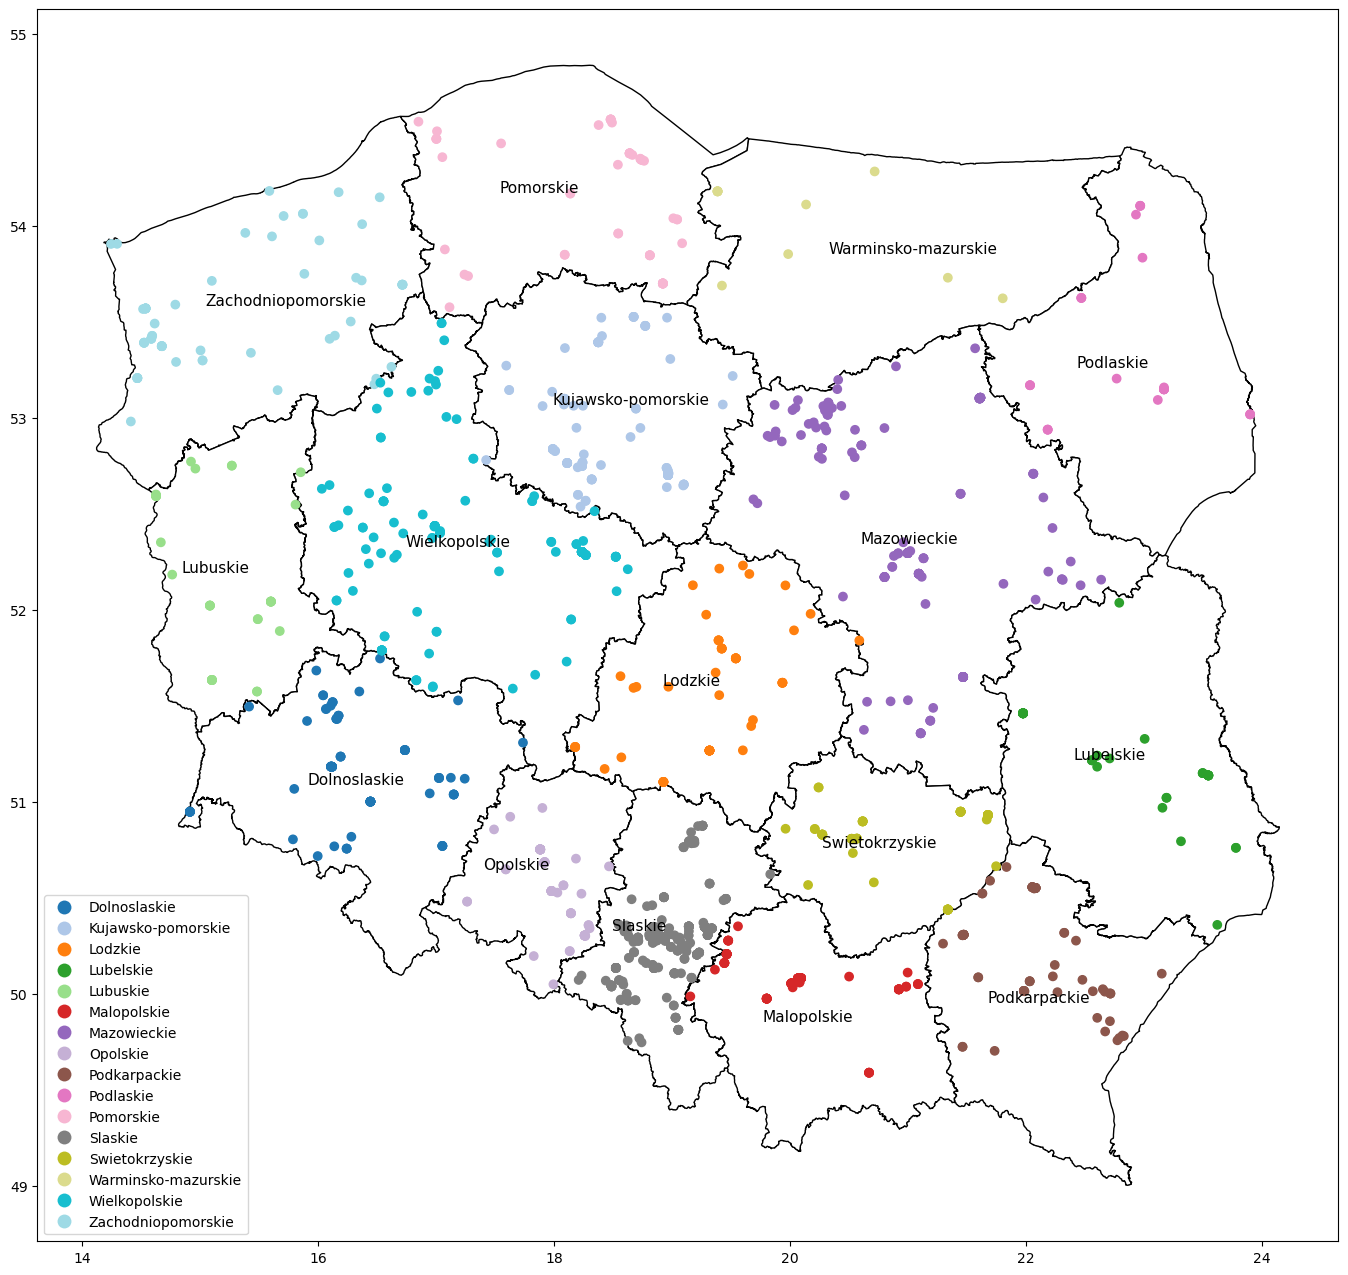

Text(0.5, 1.0, 'Provinces of Poland')

In [122]:
p = provinces.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
provinces["CENTER"] = provinces["geometry"].centroid
provinces_points = provinces.copy()
provinces_points.set_geometry(provinces["CENTER"], inplace = True)
texts = []

for x, y, label in zip(provinces_points.geometry.x, provinces_points.geometry.y, provinces_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
ind.plot(column='PROVINCE', ax=p, figsize = (20,16), legend=True, cmap='tab20')
plt.show()

p.axis('off')
p.set_title('Provinces of Poland')

We are not going to use all that information above. We need to separate the pollutant types that will be used in this study:

In [270]:
ind_ch4 = ind[ind["pollutant"]=="Methane (CH4)"].reset_index(drop=True)
ind_nox = ind[ind["pollutant"]=="Nitrogen oxides (NOX)"].reset_index(drop=True)
ind_nmvoc = ind[ind["pollutant"]=="Non-methane volatile organic compounds (NMVOC)"].reset_index(drop=True)
ind_n2o = ind[ind["pollutant"]=="Nitrous oxide (N2O)"].reset_index(drop=True)

ind_n2o

,index,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry,PROVINCE
0,24,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000010.FACILITY,Zakład Wytwarzania Nowa,NaN,19.276722,50.347805,NaN,Dąbrowa Górnicza,AIR,Nitrous oxide (N2O),94500.0,2019,NaN,POINT (19.27672 50.34781),Slaskie
1,58,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000031.FACILITY,ENEA Wytwarzanie Spółka z ograniczoną odpowied...,NaN,21.466667,51.650002,NaN,Świerże Górne,AIR,Nitrous oxide (N2O),19700.0,2019,NaN,POINT (21.46667 51.65000),Mazowieckie
2,71,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000034.FACILITY,Elektrociepłownia Gdańska,NaN,18.640436,54.377743,NaN,Gdańsk,AIR,Nitrous oxide (N2O),17600.0,2019,NaN,POINT (18.64044 54.37774),Pomorskie
3,208,Poland,5.0,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,PL.MŚ/000000108.FACILITY,Grupa Azoty Zakłady Azotowe Kędzierzyn Spółka ...,NaN,18.259420,50.303394,NaN,Kędzierzyn-Koźle,AIR,Nitrous oxide (N2O),349000.0,2019,NaN,POINT (18.25942 50.30339),Opolskie
4,232,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000122.FACILITY,TAURON Wytwarzanie Spółka Akcyjna - Oddział E...,NaN,19.229445,50.214169,NaN,Jaworzno,AIR,Nitrous oxide (N2O),152000.0,2019,NaN,POINT (19.22944 50.21417),Slaskie
5,244,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000123.FACILITY,TAURON Wytwarzanie S.A Elektrownia Łagisza,NaN,19.141666,50.349998,NaN,Będzin,AIR,Nitrous oxide (N2O),129000.0,2019,NaN,POINT (19.14167 50.35000),Slaskie
6,254,Poland,5.0,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,PL.MŚ/000000124.FACILITY,TAURON Wytwarzanie Spółka Akcyjna - Oddział El...,NaN,19.462778,50.206390,NaN,Trzebinia,AIR,Nitrous oxide (N2O),271000.0,2019,NaN,POINT (19.46278 50.20639),Malopolskie
7,261,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000125.FACILITY,Zakład Wytwarzania Katowice,NaN,19.050528,50.284874,NaN,Katowice,AIR,Nitrous oxide (N2O),344000.0,2019,NaN,POINT (19.05053 50.28487),Slaskie
8,277,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000128.FACILITY,Zakład Wytwarzania Bielsko-Biała EC1,NaN,19.052500,49.811943,NaN,Bielsko-Biała,AIR,Nitrous oxide (N2O),38500.0,2019,NaN,POINT (19.05250 49.81194),Slaskie
9,283,Poland,1.0,Energy sector,1(c),Thermal power stations and other combustion in...,PL.MŚ/000000129.FACILITY,Zakład Wytwarzania Bielsko-Biała EC2,NaN,19.029722,49.875000,NaN,Czechowice-Dziedzice,AIR,Nitrous oxide (N2O),76800.0,2019,NaN,POINT (19.02972 49.87500),Slaskie


**Identifying missing values**:

This function below receives a dataframe and returns another dataframe with the counts of missing values in it:

In [125]:
def dfnan(df, name_pollut):
    cols = df.columns
    nan_list = []

    for i in range(len(cols)):
        counts = len(df[pd.isnull(df.iloc[:,i])])
        nan_list.append(counts)
    
    df = pd.DataFrame([nan_list], columns=cols).T
    name_pollut = "nan_" + name_pollut
    df = df.rename(columns={0: name_pollut})
        
    return df

We can use this function in each pollutant subsets and concatenate them into a new dataframe "nan_pollutants":

In [128]:
nan_ch4 = dfnan(ind_ch4, "ch4")
nan_nox = dfnan(ind_nox, "nox")
nan_nmvoc = dfnan(ind_nmvoc, "nmvoc")
nan_n2o = dfnan(ind_n2o, "n2o")

nan_pollutants = pd.concat([nan_ch4,nan_nox,nan_nmvoc,nan_n2o], axis=1)

In [129]:
nan_pollutants

,nan_ch4,nan_nox,nan_nmvoc,nan_n2o
index,0,0,0,0
countryName,0,0,0,0
EPRTRSectorCode,1,0,0,0
eprtrSectorName,1,0,0,0
EPRTRAnnexIMainActivityCode,1,0,0,0
EPRTRAnnexIMainActivityLabel,1,0,0,0
FacilityInspireID,0,0,0,0
facilityName,0,0,0,0
facilityNameConfidentialityReason,81,165,25,32
Longitude,0,0,0,0


Now we can plot "nan_pollutants" to have an overview of all "not a number" values per subset:

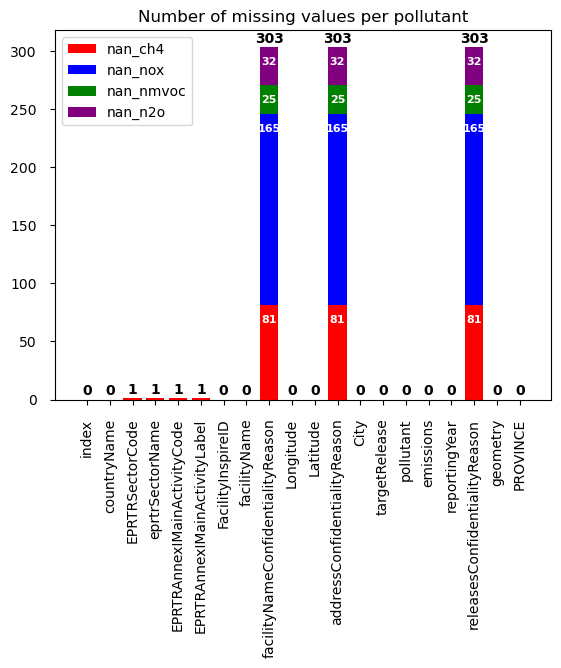

In [130]:
fig, ax = plt.subplots()

colors = ['red', 'blue','green', 'purple']
bottom = np.zeros(len(nan_pollutants))

for i, col in enumerate(nan_pollutants.columns):
  ax.bar(
      nan_pollutants.index, nan_pollutants[col], bottom=bottom, label=col, color=colors[i])
  bottom += np.array(nan_pollutants[col])

totals = nan_pollutants.sum(axis=1)
y_offset = 4
for i, total in enumerate(totals):
  ax.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold')

# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -15
# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches:
  ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height() + bar.get_y() + y_offset,
      # This is actual value we'll show.
      round(bar.get_height()),
      # Center the labels and style them a bit.
      ha='center',
      color='w',
      weight='bold',
      size=8
  )

plt.xticks(rotation=90)
ax.tick_params(axis='both', which='major', pad=10)
ax.set_title('Number of missing values per pollutant')
ax.legend()

In the graphic above, we see that the majority of the information with missing values are not relevant for this study. However, the subset **"nan_CH4"** has one important column (**eprtrsSectorName**) without information. As it is only 1 missing value out of 81 normal values, we decided just to remove this row.

In [272]:
ind_ch4[ind_ch4["eprtrSectorName"].isna()]

,index,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,geometry,PROVINCE
33,1086,Poland,NaN,NaN,NaN,NaN,PL.MŚ/000001594.FACILITY,Przedsiębiorstwo Użyteczności Publicznej EKOSK...,NaN,18.647778,52.900002,NaN,Służewo,AIR,Methane (CH4),160000.0,2019,NaN,POINT (18.64778 52.90000),Kujawsko-pomorskie


In [273]:
idx_to_be_deleted = ind_ch4[ind_ch4["eprtrSectorName"].isna()].index

In [274]:
ind_ch4_clean = ind_ch4.drop(idx_to_be_deleted).reset_index(drop=True)

## Sum of emissions for each pollutant per province

We are going to combine the data in a way to get the total pollutants' emissions per province. Below we made a function to receive a base dataframe which will be fed by another dataframe with the emissions per province and sum them up in the base dataframe:

In [149]:
sum_per_province = provinces.copy()

In [144]:
def sum_emissions(df_base, df_additional, new_feature):
    df_base[new_feature]=0
    for i in range(len(df_base)):
        name = df_base["NAME"][i]
        df = df_additional[df_additional["PROVINCE"]==name]
        sum_emissions = sum(df["emissions"])
        df_base[new_feature][i]=sum_emissions
    return df_base

Adding one by one the new features with the summed up emissions:

In [150]:
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_ch4_clean, new_feature="EMISSIONS_CH4")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_nox, new_feature="EMISSIONS_NOx")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_nmvoc, new_feature="EMISSIONS_NMVOC")
sum_per_province = sum_emissions(df_base=sum_per_province, df_additional=ind_n2o, new_feature="EMISSIONS_N2O")

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\3079581083.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base[new_feature][i]=sum_emissions
C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\3079581083.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base[new_feature][i]=sum_emissions
C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\3079581083.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base[new_feature][i]=sum

In [163]:
sum_per_province.head(2)

,NAME,AREA,geometry,CENTER,EMISSIONS_CH4,EMISSIONS_NOx,EMISSIONS_NMVOC,EMISSIONS_N2O
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),1561000,4983000,0,0
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),72668000,2230000,0,78900


Overview of the total emissions of one of the pollutants (NMVOC) per province:

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\2764376423.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sum_per_province["CENTER"] = sum_per_province["geometry"].centroid


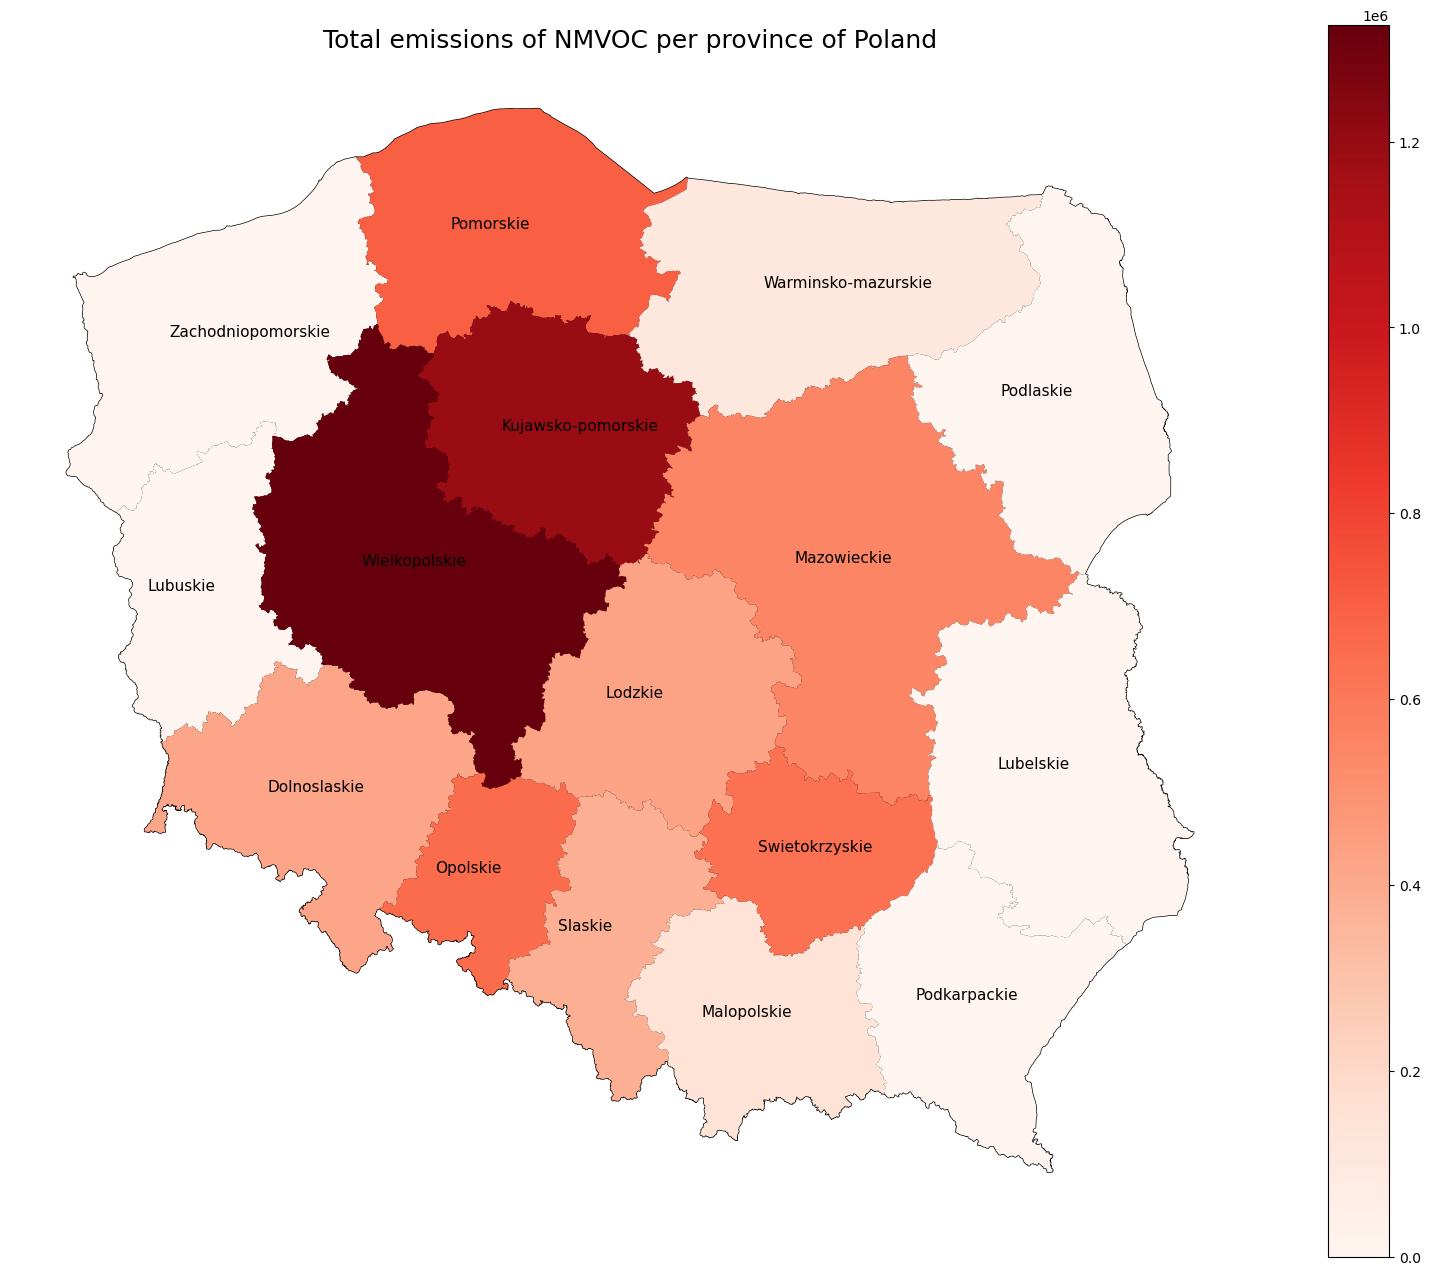

In [162]:
p = sum_per_province.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
sum_per_province["CENTER"] = sum_per_province["geometry"].centroid
sum_per_province_points = sum_per_province.copy()
sum_per_province_points.set_geometry(sum_per_province["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sum_per_province_points.geometry.x, 
                       sum_per_province_points.geometry.y, 
                       sum_per_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sum_per_province.plot(column='EMISSIONS_NMVOC', ax=p, figsize = (20,16), legend=True, cmap='Reds')

p.axis('off')
p.set_title('Total emissions of NMVOC per province of Poland', fontsize=18)
plt.show()

---

## Distribution of emissions from each sector per province

In [299]:
sector_province = provinces.copy()

In [300]:
sector_province

,NAME,AREA,geometry,CENTER
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506)
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617)
2,Dolnoslaskie,2.55916927233,"POLYGON ((16.91342 50.44976, 16.91210 50.44982...",POINT (16.41069 51.08950)
3,Wielkopolskie,3.93220020515,"POLYGON ((18.14065 52.50609, 18.14115 52.50605...",POINT (17.24310 52.33078)
4,Pomorskie,2.68945114136,"POLYGON ((18.82439 54.62561, 18.82619 54.62326...",POINT (18.03790 54.17734)
5,Opolskie,1.19620046778,"POLYGON ((17.74135 50.28711, 17.74138 50.28771...",POINT (17.89988 50.64711)
6,Kujawsko-pomorskie,2.40941372674,"POLYGON ((18.14065 52.50609, 18.14011 52.50601...",POINT (18.48822 53.07270)
7,Slaskie,1.55733578555,"MULTIPOLYGON (((19.83803 50.59001, 19.83754 50...",POINT (18.99410 50.33108)
8,Lodzkie,2.36362021645,"POLYGON ((20.42486 51.61167, 20.42489 51.61162...",POINT (19.41760 51.60487)
9,Malopolskie,1.8985108988,"POLYGON ((20.80878 49.35366, 20.80898 49.35375...",POINT (20.26934 49.85895)


The names of the industrial sectors are too long. Let's make a dictionary with a shorter version for those names:

In [301]:
code_sector = {'Animal and vegetable products from the food and beverage sector': "FOOD_BEVERAGE",
       'Chemical industry': "CHEMICAL", 
       'Energy sector': "ENERGY",
       'Intensive livestock production and aquaculture': "LIVESTOCK",
       'Mineral industry': "MINERAL", 
       'Other activities': "OTHER",
       'Paper and wood production and processing': "PAPER_WOOD",
       'Production and processing of metals': "METALS",
       'Waste and wastewater management': "WASTE"}

In [302]:
np.unique(ind_ch4_clean["eprtrSectorName"].dropna())

array(['Energy sector', 'Intensive livestock production and aquaculture',
       'Mineral industry', 'Other activities',
       'Waste and wastewater management'], dtype=object)

And here a function to create a new columns with the new short-version names:

In [303]:
def easier_name_for_sector(industry_dataset):
    
    for i,j in code_sector.items():
        idx = industry_dataset[industry_dataset["eprtrSectorName"]==i].index
        industry_dataset.loc[idx,"code_sector"]=j
    return industry_dataset

In [276]:
ind_ch4_clean2 = easier_name_for_sector(industry_dataset = ind_ch4_clean)
ind_nox2 = easier_name_for_sector(industry_dataset = ind_nox)
ind_nmvoc2 = easier_name_for_sector(industry_dataset = ind_nmvoc)
ind_n2o2 = easier_name_for_sector(industry_dataset = ind_n2o)
ind2 = easier_name_for_sector(industry_dataset = ind)

This function is going to create new columns associating each pollutant (CH4, NOx, NMVOC, N2O) to each sector (CHEMICAL, ENERGY, FOOD_BEVERAGE, LIVESTOCK, METALS, MINERAL, PAPER_WOOD, WASTE, OTHER) per province.

In [293]:
sectors = np.unique(ind["code_sector"].dropna())
province_names = np.unique(ind["PROVINCE"])

def sum_pollutant_sector_per_province(df_base, pollutant_df, pollutant_name):
    
    for i in range(len(province_names)):
        for j in range(len(sectors)):
            province_name = province_names[i]
            #print(province_name)
            sector_name = sectors[j]

            df = pollutant_df[(pollutant_df["code_sector"]==sector_name) & (pollutant_df["PROVINCE"]==province_name)]
            sum_emissions = sum(df["emissions"])

            column_name = sectors[j]+"_" + pollutant_name

            idx = df_base[df_base["NAME"]==province_name].index       
            df_base.loc[idx, column_name] = sum_emissions
            
    return df_base

In [304]:
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_ch4_clean, pollutant_name = "CH4")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_nox, pollutant_name = "NOx")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_nmvoc, pollutant_name = "NMVOC")
sector_province = sum_pollutant_sector_per_province(df_base = sector_province, pollutant_df = ind_n2o, pollutant_name = "N2O")

In [309]:
#sector_province[sector_province["NAME"]=="Swietokrzyskie"].T

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\1585194005.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sector_province["CENTER"] = sector_province["geometry"].centroid


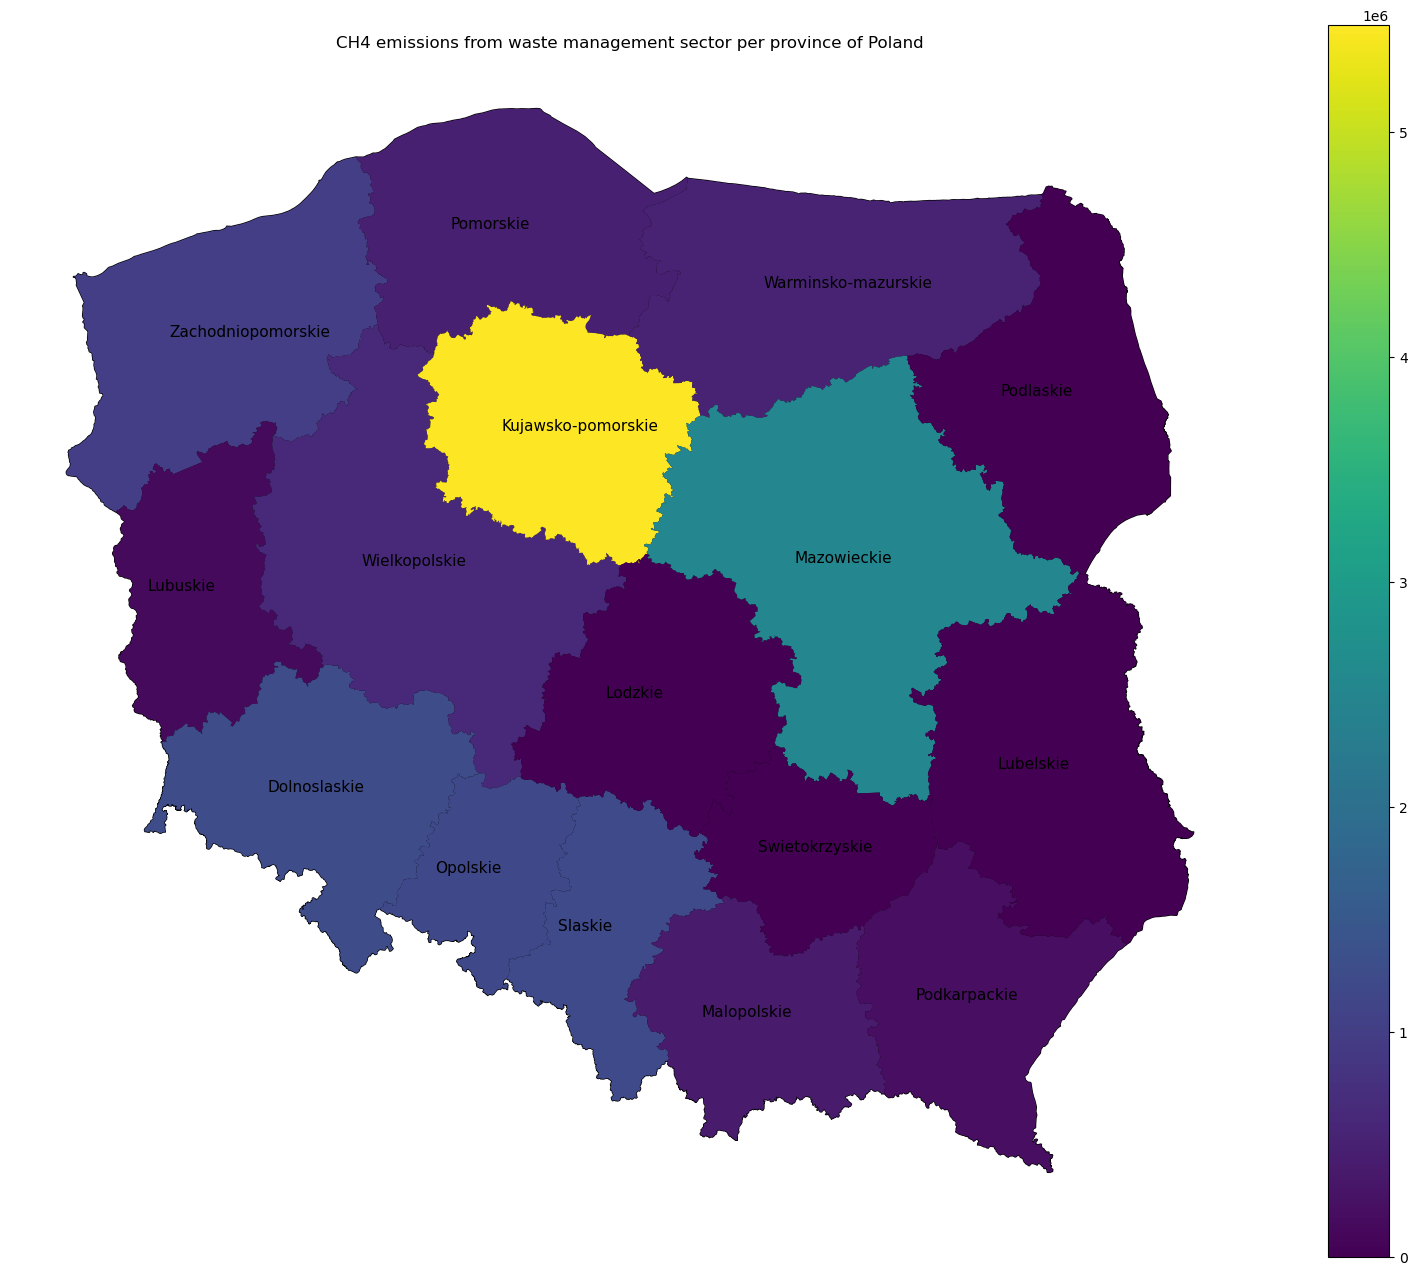

In [310]:
p = sector_province.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
sector_province["CENTER"] = sector_province["geometry"].centroid
sector_province_points = sector_province.copy()
sector_province_points.set_geometry(sector_province["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sector_province.plot(column='WASTE_CH4', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('CH4 emissions from waste management sector per province of Poland')

plt.show()

Adding traffic data to the base dataframe:

In [364]:
traffic_ch4

,Year,Voivodship,Pollutant,Urban buses,Lorries,Road tractors,Total_tonnes
0,2019,Pomorskie,CH4,1.008092,10.152335,7.174665,18.335091
1,2019,Lubelskie,CH4,0.529898,10.985181,7.297826,18.812905
2,2019,Opolskie,CH4,0.332869,3.800893,2.764323,6.898084
3,2019,Slaskie,CH4,1.998256,18.925905,11.971925,32.896086
4,2019,Swietokrzyskie,CH4,0.603980,8.871636,5.171161,14.646777
5,2019,Malopolskie,CH4,1.353894,18.831062,7.705495,27.890451
6,2019,Podkarpackie,CH4,0.730997,10.348918,5.141997,16.221913
7,2019,Warminsko-mazurskie,CH4,0.519014,6.052089,2.759125,9.330228
8,2019,Podlaskie,CH4,0.402743,6.373319,3.510939,10.287001
9,2019,Lubuskie,CH4,0.290655,4.503466,3.180627,7.974748


In [375]:
sector_province["TRAFFIC_CH4"]=0
sector_province["TRAFFIC_N2O"]=0
sector_province["TRAFFIC_NMVOC"]=0
sector_province["TRAFFIC_NOX"]=0

def add_traffic(df_base, df_to_add, new_column_name):

    for i in range(len(df_base)):
    
        name = df_to_add["Voivodship"][i]
        quantity = df_to_add[df_to_add["Voivodship"]==name]["Total_kg"]
        idx = df_base[df_base["NAME"]==name].index
        df_base.loc[idx, new_column_name]=quantity[i]


In [376]:
add_traffic(df_base = sector_province, df_to_add = traffic_ch4, new_column_name = "TRAFFIC_CH4")
add_traffic(df_base = sector_province, df_to_add = traffic_n2o, new_column_name = "TRAFFIC_N2O")
add_traffic(df_base = sector_province, df_to_add = traffic_nmvoc, new_column_name = "TRAFFIC_NMVOC")
add_traffic(df_base = sector_province, df_to_add = traffic_nox, new_column_name = "TRAFFIC_NOX")

In [313]:
sector_province.head(2)

,NAME,AREA,geometry,CENTER,CHEMICAL_CH4,ENERGY_CH4,FOOD_BEVERAGE_CH4,LIVESTOCK_CH4,METALS_CH4,MINERAL_CH4,...,LIVESTOCK_N2O,METALS_N2O,MINERAL_N2O,OTHER_N2O,PAPER_WOOD_N2O,WASTE_N2O,TRAFFIC_CH4,TRAFFIC_N2O,TRAFFIC_NMVOC,TRAFFIC_NOX
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,561000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.638690,31.269646,43.952368,2030.799150
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),0.0,0.0,0.0,0.0,0.0,72520000.0,...,0.0,0.0,78900.0,0.0,0.0,0.0,7.974748,26.772646,31.488322,1410.837009


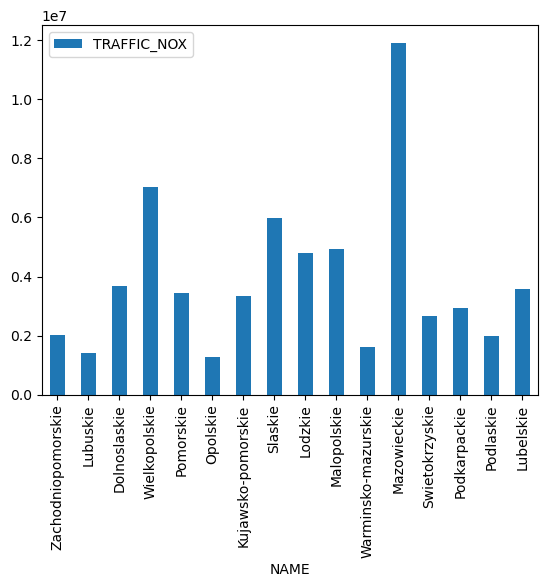

In [379]:
ax = sector_province.plot.bar(x='NAME', y='TRAFFIC_NOX', rot=90)

In [380]:
sector_province

,NAME,AREA,geometry,CENTER,CHEMICAL_CH4,ENERGY_CH4,FOOD_BEVERAGE_CH4,LIVESTOCK_CH4,METALS_CH4,MINERAL_CH4,...,LIVESTOCK_N2O,METALS_N2O,MINERAL_N2O,OTHER_N2O,PAPER_WOOD_N2O,WASTE_N2O,TRAFFIC_CH4,TRAFFIC_N2O,TRAFFIC_NMVOC,TRAFFIC_NOX
0,Zachodniopomorskie,3.10794349875,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,561000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11638.689972,31269.646109,43952.368059,2.030799e+06
1,Lubuskie,1.83850176383,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),0.0,0.0,0.0,0.0,0.0,72520000.0,...,0.0,0.0,78900.0,0.0,0.0,0.0,7974.747629,26772.646467,31488.321870,1.410837e+06
2,Dolnoslaskie,2.55916927233,"POLYGON ((16.91342 50.44976, 16.91210 50.44982...",POINT (16.41069 51.08950),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20884.222273,60240.826750,80021.972450,3.662470e+06
3,Wielkopolskie,3.93220020515,"POLYGON ((18.14065 52.50609, 18.14115 52.50605...",POINT (17.24310 52.33078),0.0,192000.0,0.0,0.0,0.0,21030000.0,...,88500.0,0.0,0.0,0.0,0.0,0.0,39512.142727,135023.286430,156640.965800,7.030304e+06
4,Pomorskie,2.68945114136,"POLYGON ((18.82439 54.62561, 18.82619 54.62326...",POINT (18.03790 54.17734),0.0,0.0,0.0,0.0,0.0,0.0,...,13500.0,0.0,0.0,0.0,0.0,0.0,18335.090912,51366.090120,70954.811300,3.435681e+06
5,Opolskie,1.19620046778,"POLYGON ((17.74135 50.28711, 17.74138 50.28771...",POINT (17.89988 50.64711),0.0,0.0,0.0,112000.0,0.0,0.0,...,11700.0,0.0,0.0,0.0,0.0,349000.0,6898.084441,16057.222969,25930.371229,1.281375e+06
6,Kujawsko-pomorskie,2.40941372674,"POLYGON ((18.14065 52.50609, 18.14011 52.50601...",POINT (18.48822 53.07270),0.0,155000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,194000.0,17973.168800,41018.953786,67587.004360,3.345258e+06
7,Slaskie,1.55733578555,"MULTIPOLYGON (((19.83803 50.59001, 19.83754 50...",POINT (18.99410 50.33108),0.0,91032000.0,0.0,220000.0,0.0,230732000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32896.085506,83971.278240,125089.462820,5.974575e+06
8,Lodzkie,2.36362021645,"POLYGON ((20.42486 51.61167, 20.42489 51.61162...",POINT (19.41760 51.60487),0.0,0.0,0.0,0.0,0.0,1420000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26851.228902,55061.341870,98497.891630,4.786257e+06
9,Malopolskie,1.8985108988,"POLYGON ((20.80878 49.35366, 20.80898 49.35375...",POINT (20.26934 49.85895),0.0,2850000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,271000.0,27890.451085,61891.791920,102698.474540,4.924869e+06


# Separando os dados:

In [381]:
sector_province_ch4_features = ['NAME', 'geometry', 'CENTER','CHEMICAL_CH4', 'ENERGY_CH4',
       'FOOD_BEVERAGE_CH4', 'LIVESTOCK_CH4', 'METALS_CH4', 'MINERAL_CH4',
       'OTHER_CH4', 'PAPER_WOOD_CH4', 'WASTE_CH4', 'TRAFFIC_CH4']

sector_province_nox_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_NOx',
       'ENERGY_NOx', 'FOOD_BEVERAGE_NOx', 'LIVESTOCK_NOx', 'METALS_NOx',
       'MINERAL_NOx', 'OTHER_NOx', 'PAPER_WOOD_NOx', 'WASTE_NOx', 'TRAFFIC_NOX']

sector_province_nmvoc_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_NMVOC', 'ENERGY_NMVOC', 'FOOD_BEVERAGE_NMVOC',
       'LIVESTOCK_NMVOC', 'METALS_NMVOC', 'MINERAL_NMVOC', 'OTHER_NMVOC',
       'PAPER_WOOD_NMVOC', 'WASTE_NMVOC', 'TRAFFIC_NMVOC']
 
sector_province_n2o_features = ['NAME', 'geometry', 'CENTER', 'CHEMICAL_N2O', 'ENERGY_N2O',
       'FOOD_BEVERAGE_N2O', 'LIVESTOCK_N2O', 'METALS_N2O', 'MINERAL_N2O',
       'OTHER_N2O', 'PAPER_WOOD_N2O', 'WASTE_N2O', 'TRAFFIC_N2O']
 
traffic_province_pollutants_features = ['NAME', 'geometry', 'CENTER', 'TRAFFIC_CH4', 'TRAFFIC_N2O', 'TRAFFIC_NMVOC', 'TRAFFIC_NOX']

sector_province_ch4 = sector_province[sector_province_ch4_features]
sector_province_nox = sector_province[sector_province_nox_features]
sector_province_nmvoc = sector_province[sector_province_nmvoc_features]
sector_province_n2o = sector_province[sector_province_n2o_features]
traffic_province_pollutants = sector_province[traffic_province_pollutants_features]

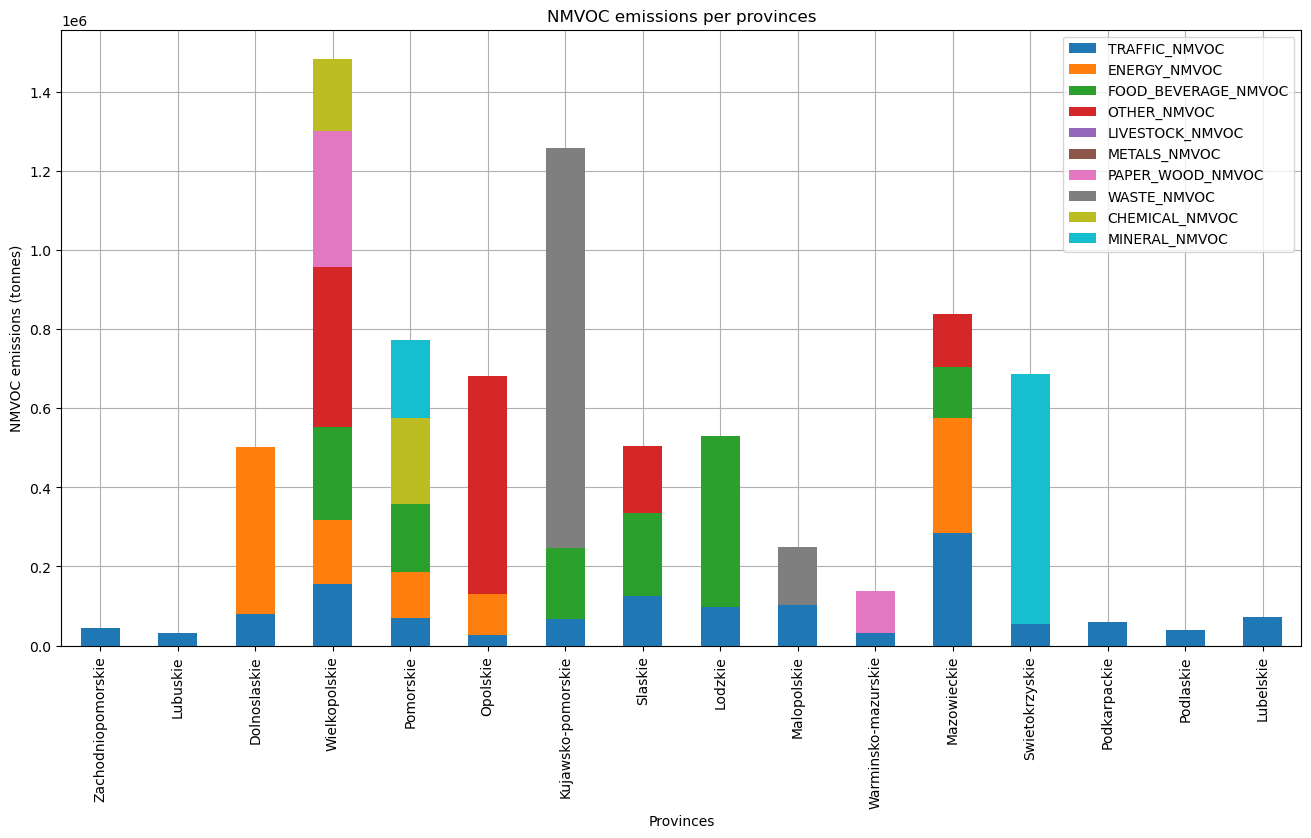

In [413]:
dftemp = sector_province_nmvoc.copy()
dftemp.index = dftemp["NAME"]

order = ['TRAFFIC_NMVOC', 'ENERGY_NMVOC', 'FOOD_BEVERAGE_NMVOC','OTHER_NMVOC',
       'LIVESTOCK_NMVOC', 'METALS_NMVOC', 
       'PAPER_WOOD_NMVOC', 'WASTE_NMVOC', 'CHEMICAL_NMVOC', 'MINERAL_NMVOC']

dftemp[order].plot(kind='bar', stacked=True, figsize = (16,8), zorder=3)
plt.title("NMVOC emissions per provinces")
plt.xlabel("Provinces")
plt.ylabel("NMVOC emissions (kg)")

plt.grid(zorder=0)

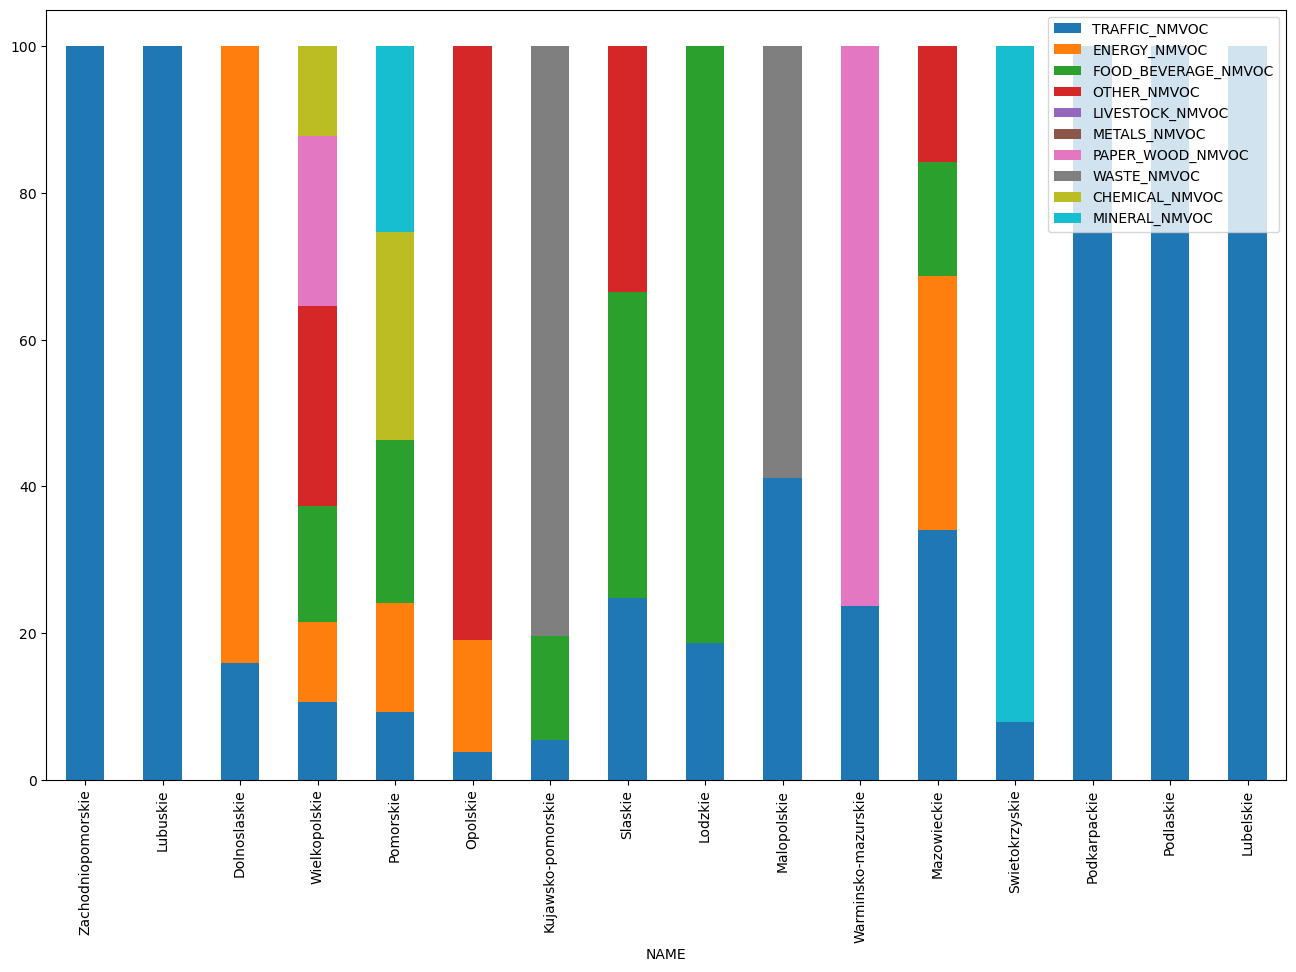

In [409]:
dftemp = sector_province_nmvoc.copy()
dftemp.index = dftemp["NAME"]

stacked_data = dftemp[order].apply(lambda x: x*100/sum(x), axis=1)
ax = stacked_data.plot(kind="bar", stacked=True, figsize = (16,10))

# for container in ax.containers:
#     ax.bar_label(container)

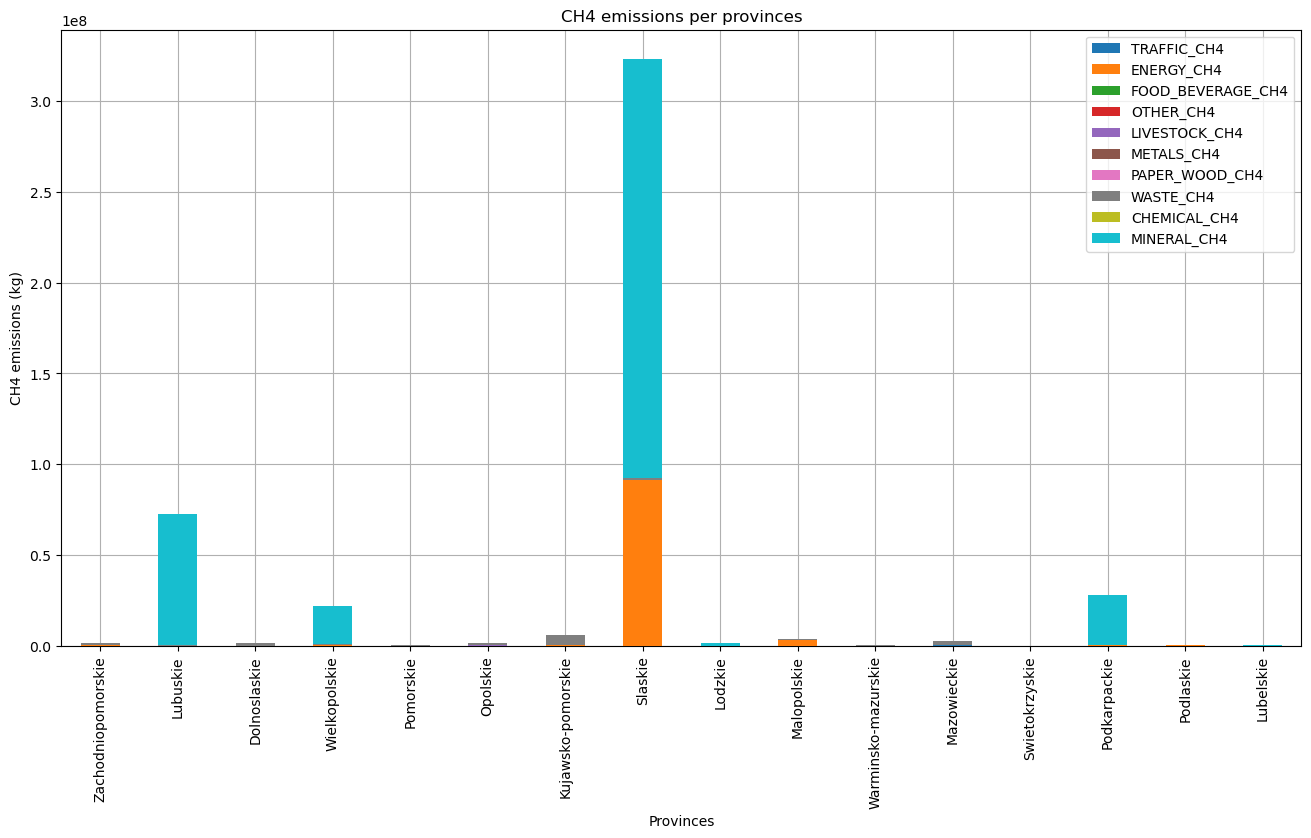

In [414]:
dftemp = sector_province_ch4.copy()
dftemp.index = dftemp["NAME"]

order = ['TRAFFIC_CH4', 'ENERGY_CH4', 'FOOD_BEVERAGE_CH4','OTHER_CH4',
       'LIVESTOCK_CH4', 'METALS_CH4', 
       'PAPER_WOOD_CH4', 'WASTE_CH4', 'CHEMICAL_CH4', 'MINERAL_CH4']

dftemp[order].plot(kind='bar', stacked=True, figsize = (16,8), zorder=3)
plt.title("CH4 emissions per provinces")
plt.xlabel("Provinces")
plt.ylabel("CH4 emissions (kg)")

plt.grid(zorder=0)

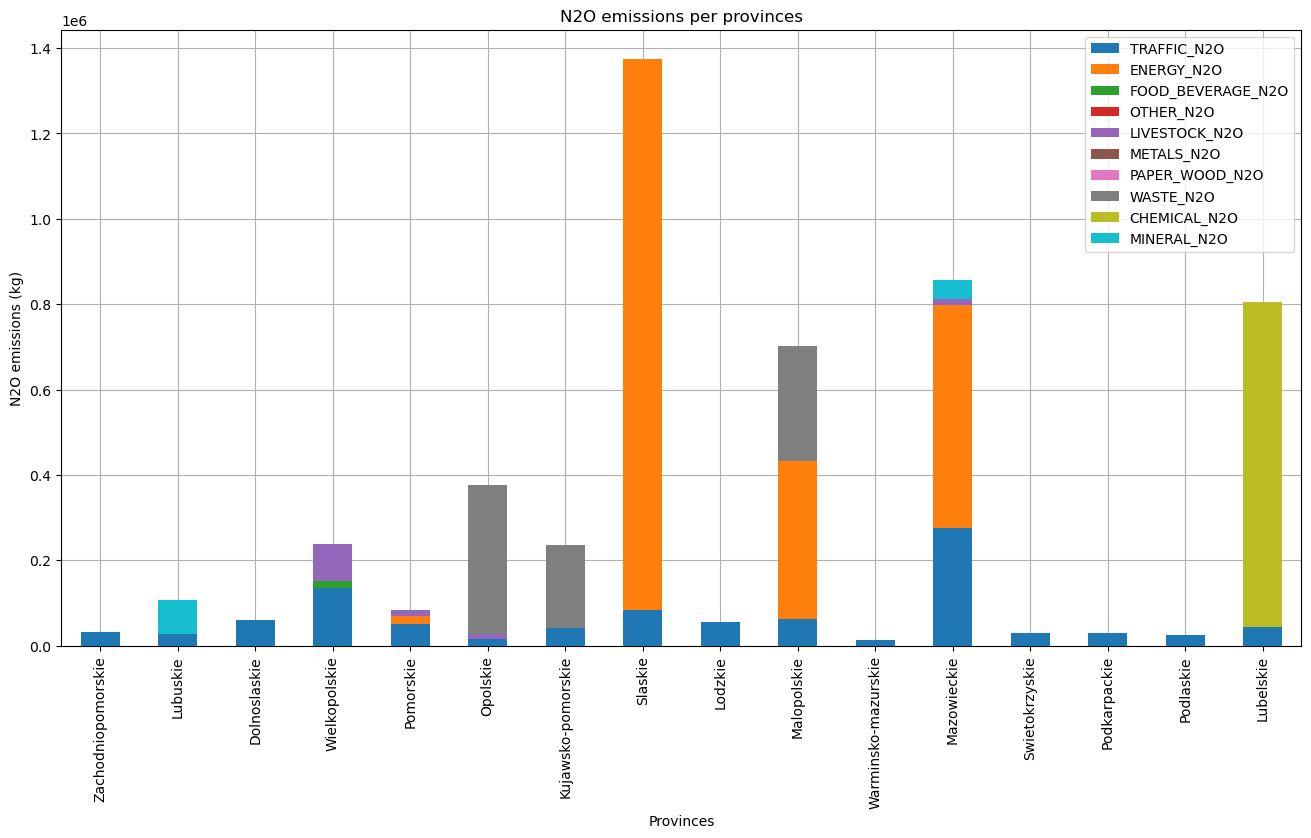

In [415]:
dftemp = sector_province_n2o.copy()
dftemp.index = dftemp["NAME"]

order = ['TRAFFIC_N2O', 'ENERGY_N2O', 'FOOD_BEVERAGE_N2O','OTHER_N2O',
       'LIVESTOCK_N2O', 'METALS_N2O', 
       'PAPER_WOOD_N2O', 'WASTE_N2O', 'CHEMICAL_N2O', 'MINERAL_N2O']

dftemp[order].plot(kind='bar', stacked=True, figsize = (16,8), zorder=3)
plt.title("N2O emissions per provinces")
plt.xlabel("Provinces")
plt.ylabel("N2O emissions (kg)")

plt.grid(zorder=0)

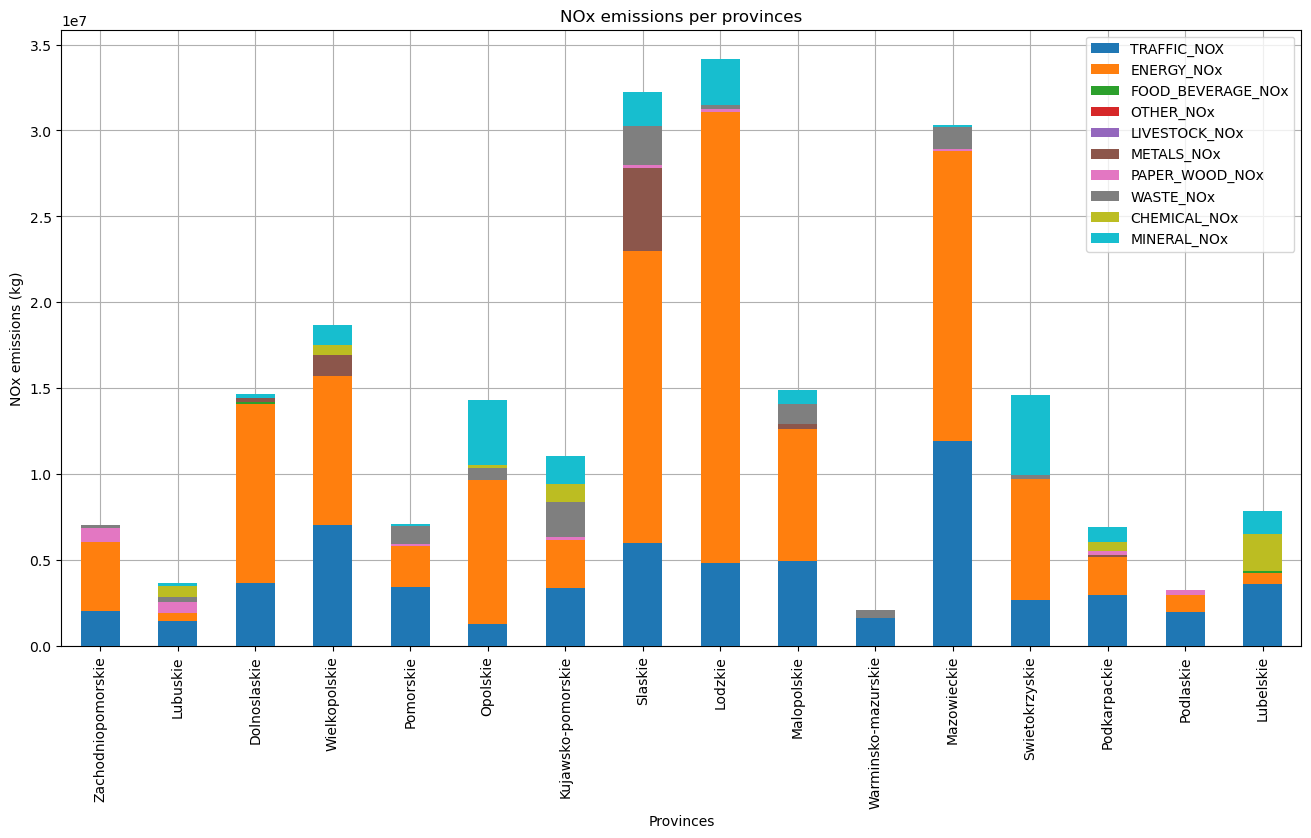

In [419]:
dftemp = sector_province_nox.copy()
dftemp.index = dftemp["NAME"]

order = ['TRAFFIC_NOX', 'ENERGY_NOx', 'FOOD_BEVERAGE_NOx','OTHER_NOx',
       'LIVESTOCK_NOx', 'METALS_NOx', 
       'PAPER_WOOD_NOx', 'WASTE_NOx', 'CHEMICAL_NOx', 'MINERAL_NOx']

dftemp[order].plot(kind='bar', stacked=True, figsize = (16,8), zorder=3)
plt.title("NOx emissions per provinces")
plt.xlabel("Provinces")
plt.ylabel("NOx emissions (kg)")

plt.grid(zorder=0)

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\3105975139.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sector_province_nox["CENTER"] = sector_province_nox["geometry"].centroid
C:\Users\hudso\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


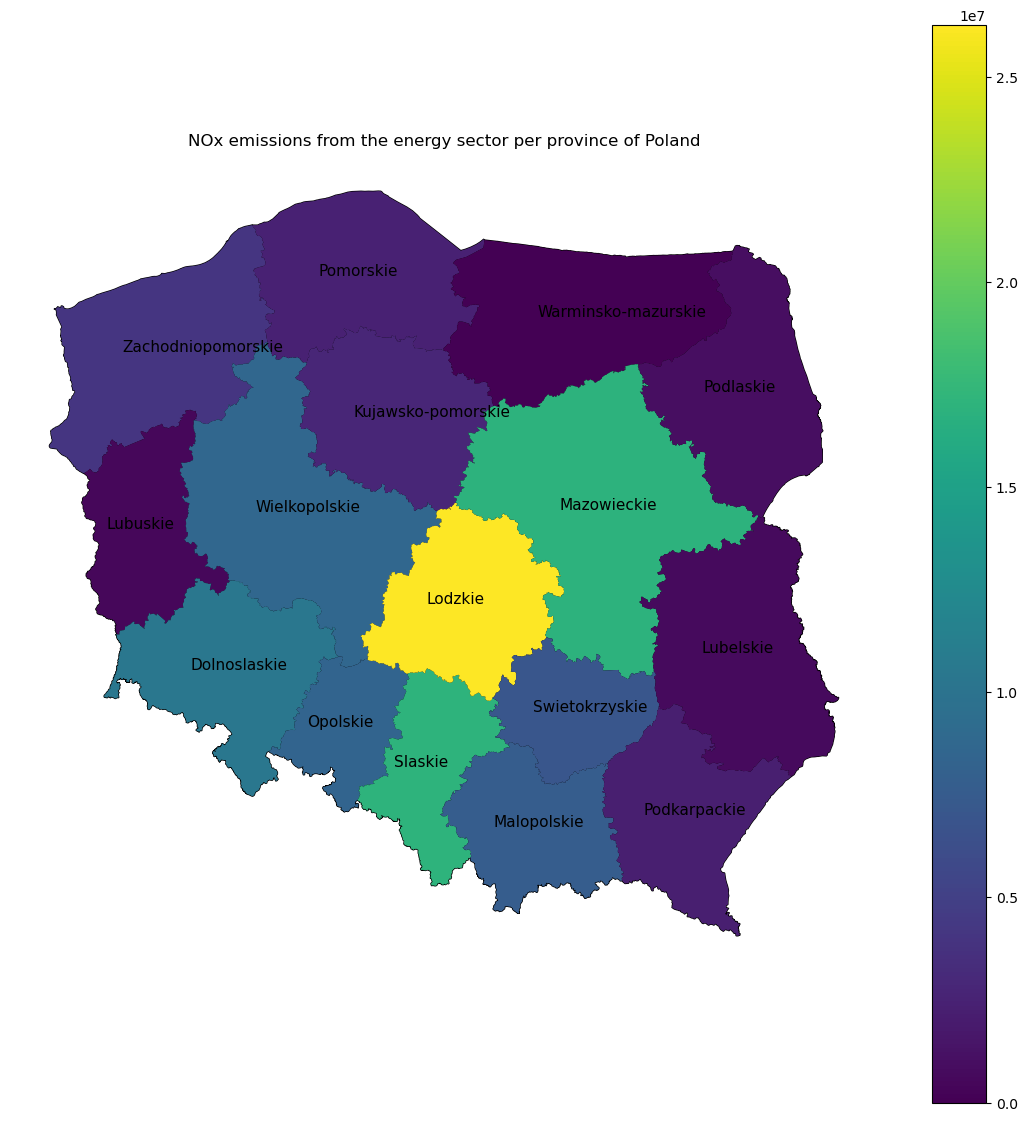

In [424]:
p = sector_province_nox.plot(color="white", edgecolor="black", figsize = (14,14))

sector_province_nox["CENTER"] = sector_province_nox["geometry"].centroid
sector_province_points = sector_province_nox.copy()
sector_province_points.set_geometry(sector_province_nox["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sector_province_nox.plot(column='ENERGY_NOx', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('NOx emissions from the energy sector per province of Poland')

plt.show()

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\348618802.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sector_province_n2o["CENTER"] = sector_province_n2o["geometry"].centroid
C:\Users\hudso\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


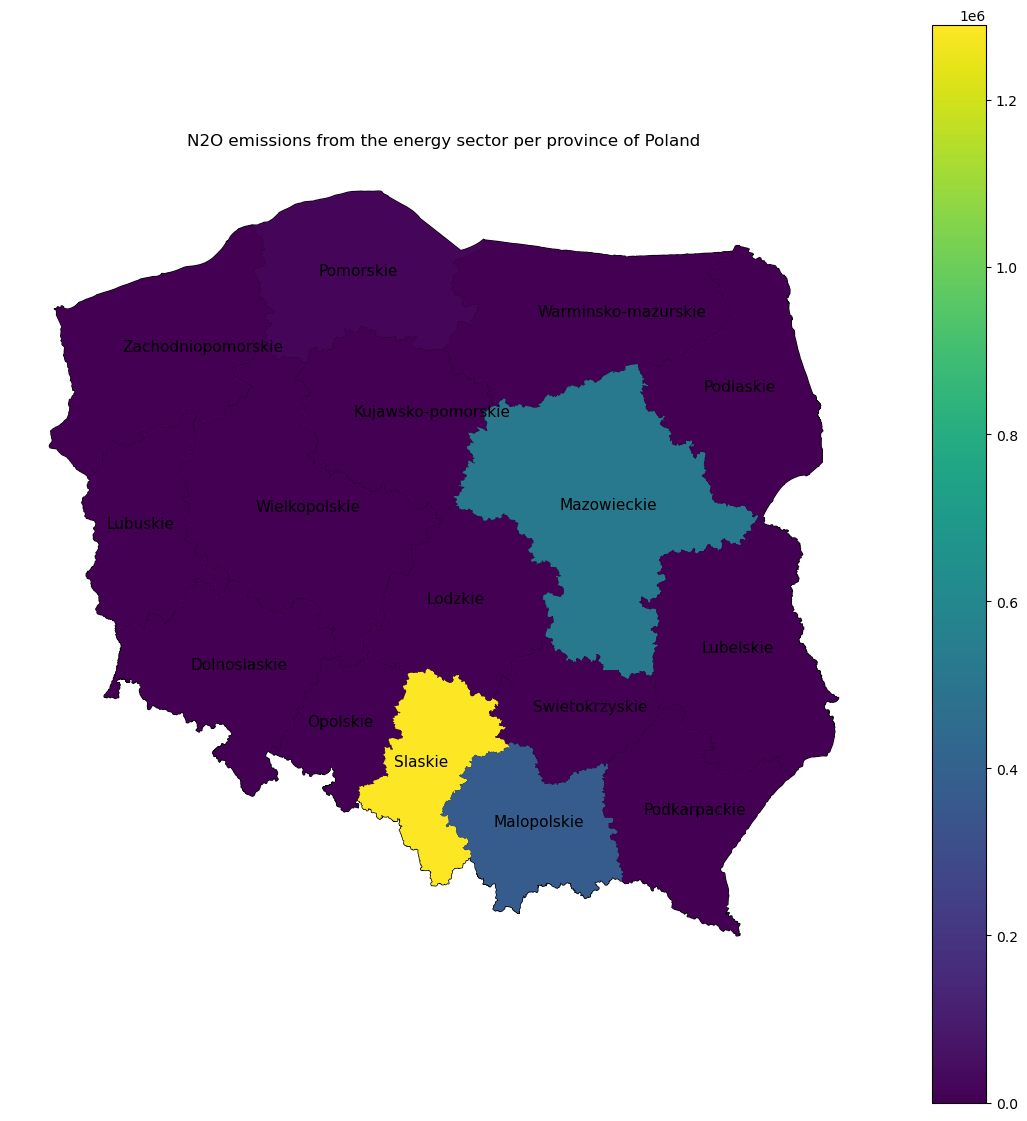

In [426]:
p = sector_province_n2o.plot(color="white", edgecolor="black", figsize = (14,14))

sector_province_n2o["CENTER"] = sector_province_n2o["geometry"].centroid
sector_province_points = sector_province_n2o.copy()
sector_province_points.set_geometry(sector_province_n2o["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sector_province_n2o.plot(column='ENERGY_N2O', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('N2O emissions from the energy sector per province of Poland')

plt.show()

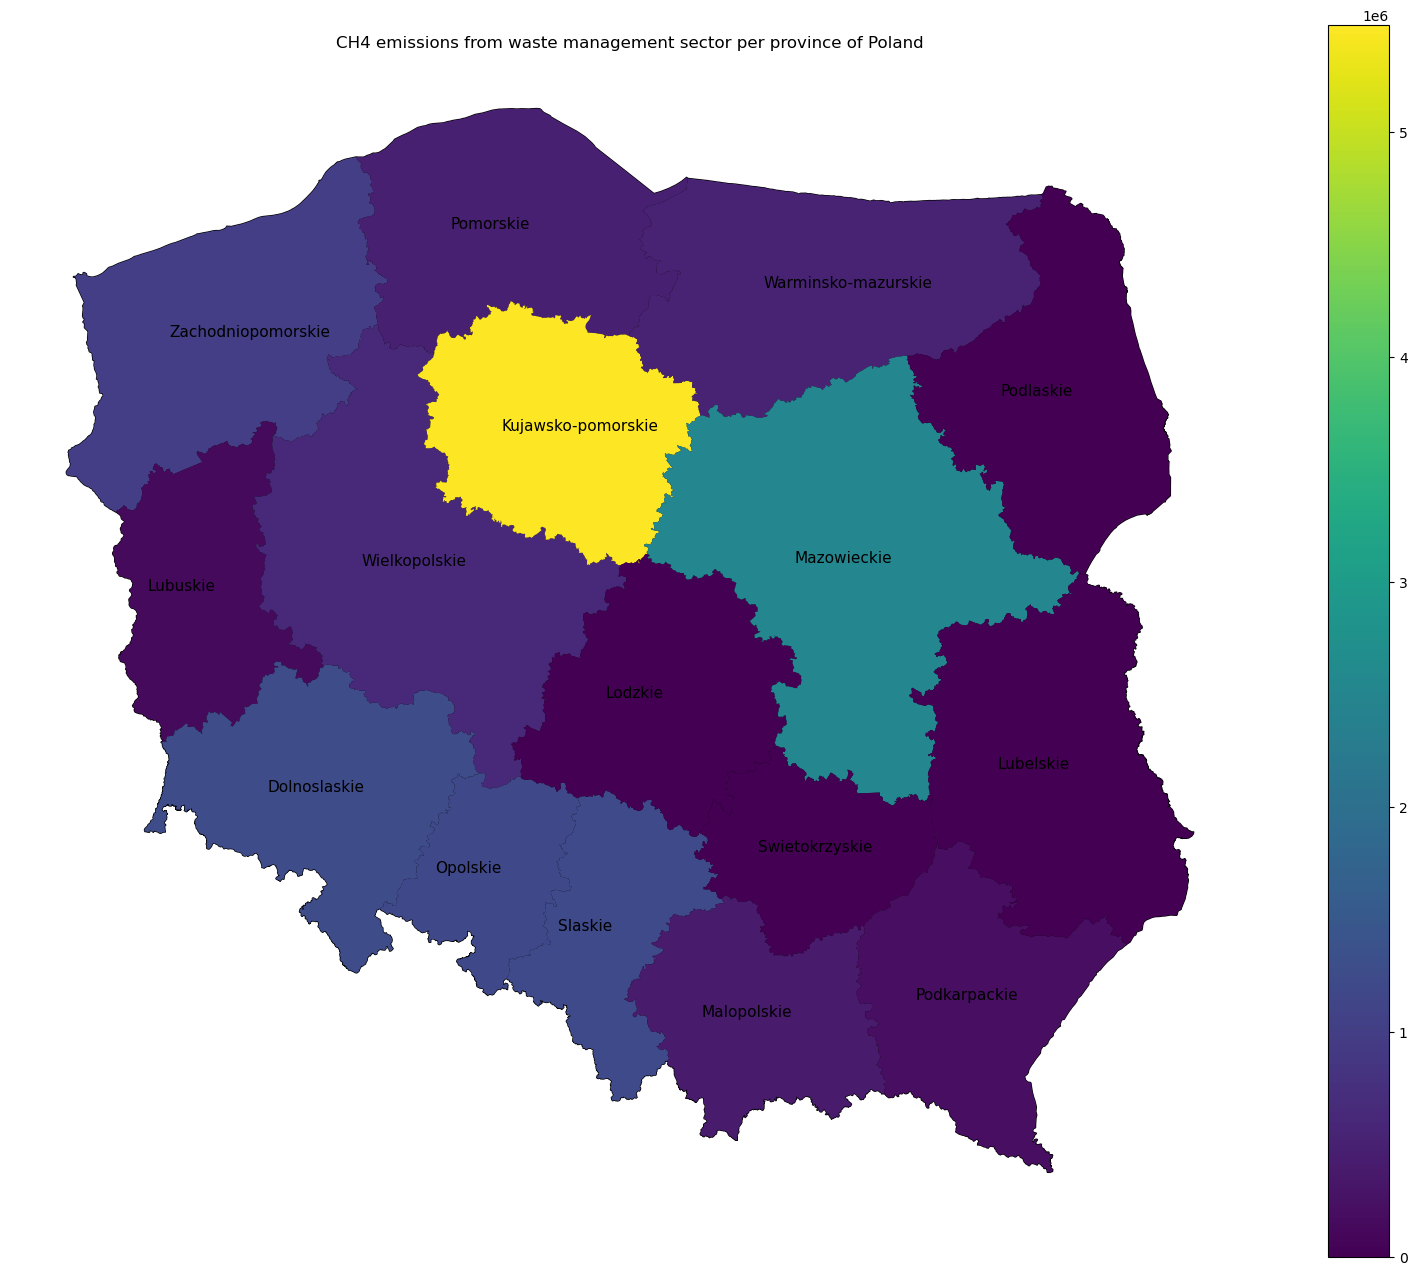

In [441]:
p = sector_province_ch4.plot(color="white", edgecolor="black", figsize = (20,16))

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sector_province_ch4.plot(column='WASTE_CH4', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('CH4 emissions from waste management sector per province of Poland')

plt.show()

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\3633220029.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sector_province_nmvoc["CENTER"] = sector_province_nmvoc["geometry"].centroid
C:\Users\hudso\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


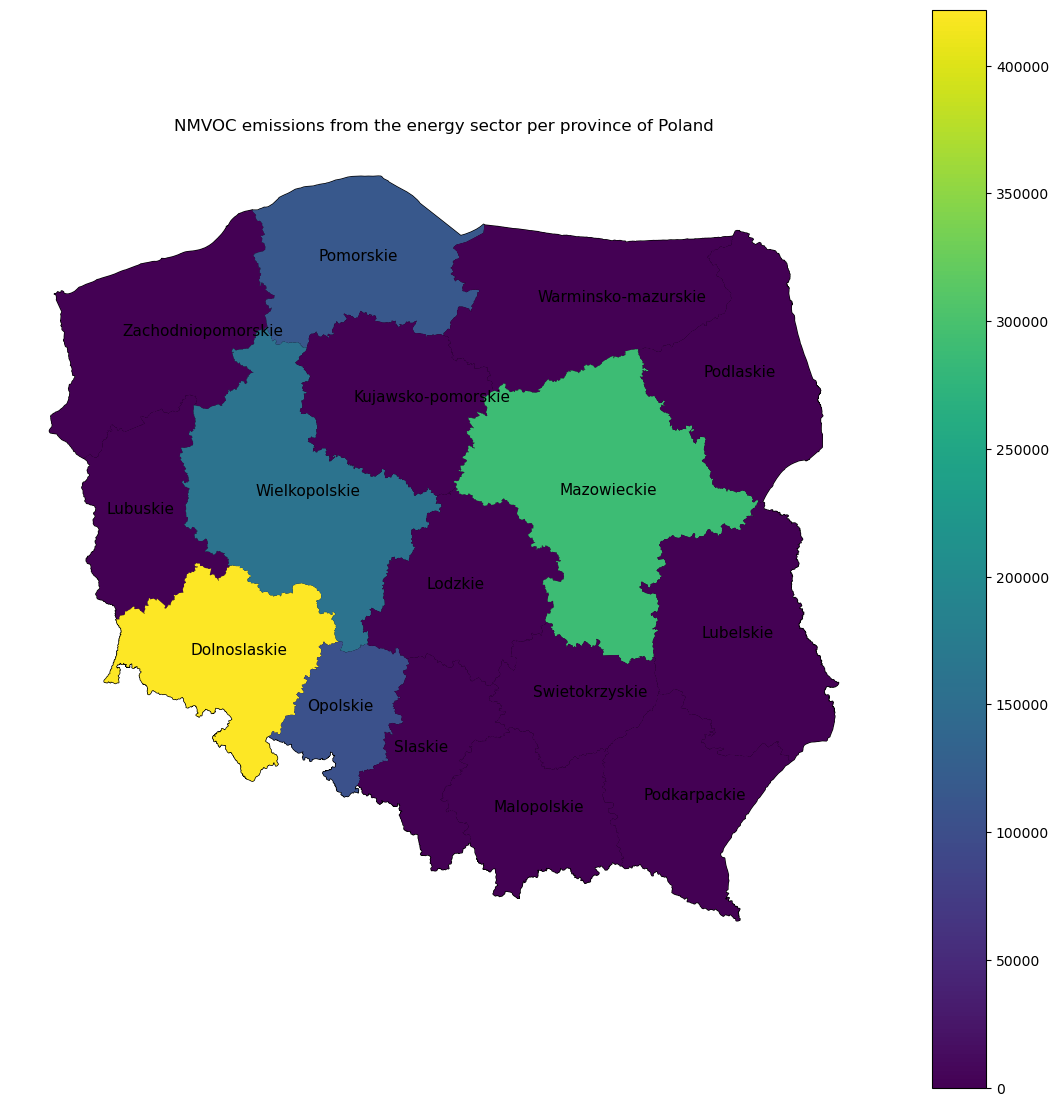

In [427]:
p = sector_province_nmvoc.plot(color="white", edgecolor="black", figsize = (14,14))

sector_province_nmvoc["CENTER"] = sector_province_nmvoc["geometry"].centroid
sector_province_points = sector_province_nmvoc.copy()
sector_province_points.set_geometry(sector_province_nmvoc["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
sector_province_nmvoc.plot(column='ENERGY_NMVOC', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('NMVOC emissions from the energy sector per province of Poland')

plt.show()

C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\795100169.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  traffic_province_pollutants["CENTER"] = traffic_province_pollutants["geometry"].centroid
C:\Users\hudso\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


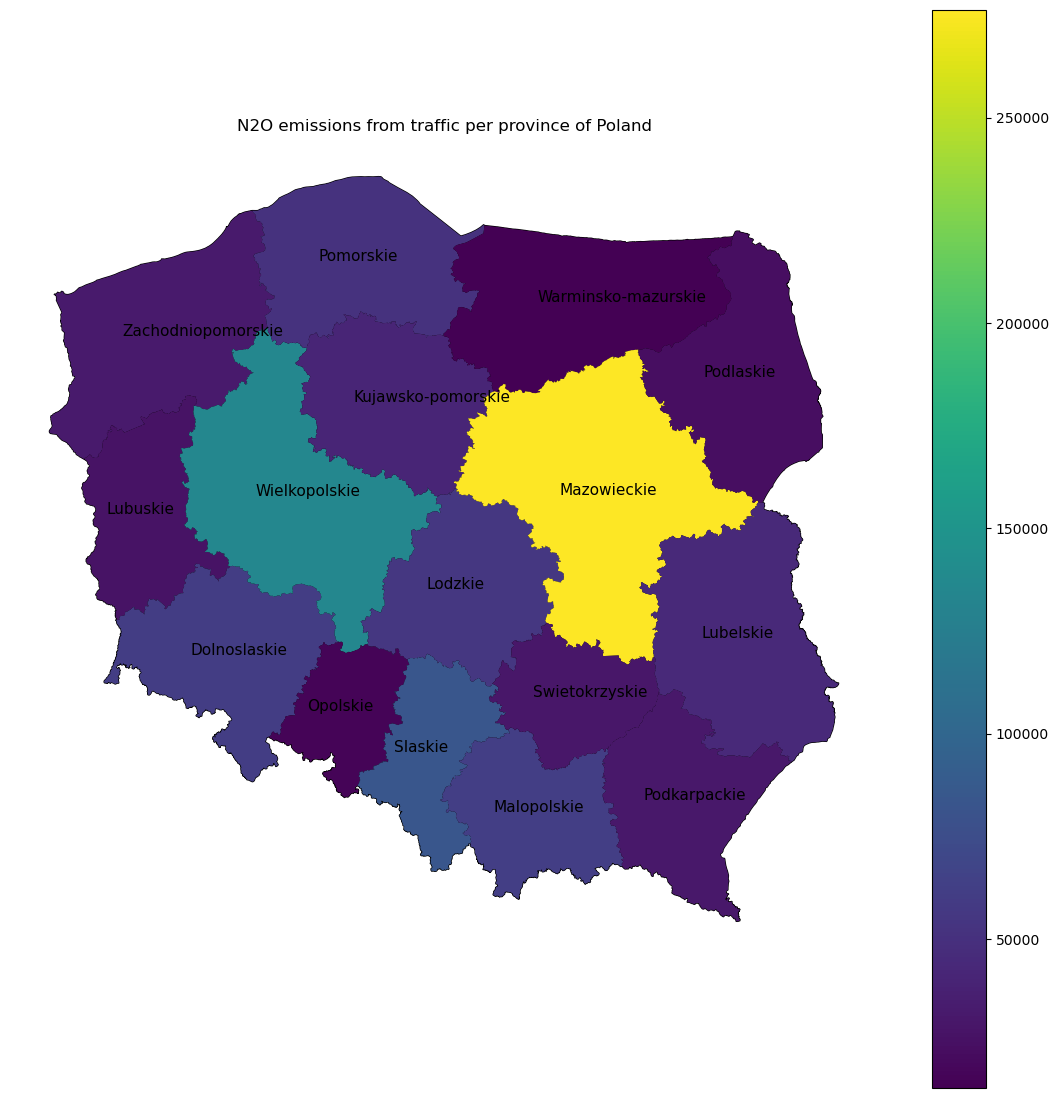

In [430]:
p = traffic_province_pollutants.plot(color="white", edgecolor="black", figsize = (14,14))

traffic_province_pollutants["CENTER"] = traffic_province_pollutants["geometry"].centroid
sector_province_points = traffic_province_pollutants.copy()
sector_province_points.set_geometry(traffic_province_pollutants["CENTER"], inplace = True)
texts = []

for x, y, label in zip(sector_province_points.geometry.x, sector_province_points.geometry.y, sector_province_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
traffic_province_pollutants.plot(column='TRAFFIC_N2O', ax=p, figsize = (20,16), legend=True)#, cmap='Set1')

p.axis('off')
p.set_title('N2O emissions from traffic per province of Poland')

plt.show()

In [431]:
A = traffic_province_pollutants[['TRAFFIC_CH4', 'TRAFFIC_N2O', 'TRAFFIC_NMVOC', 'TRAFFIC_NOX']]
A.index = list(traffic_province_pollutants['NAME'])

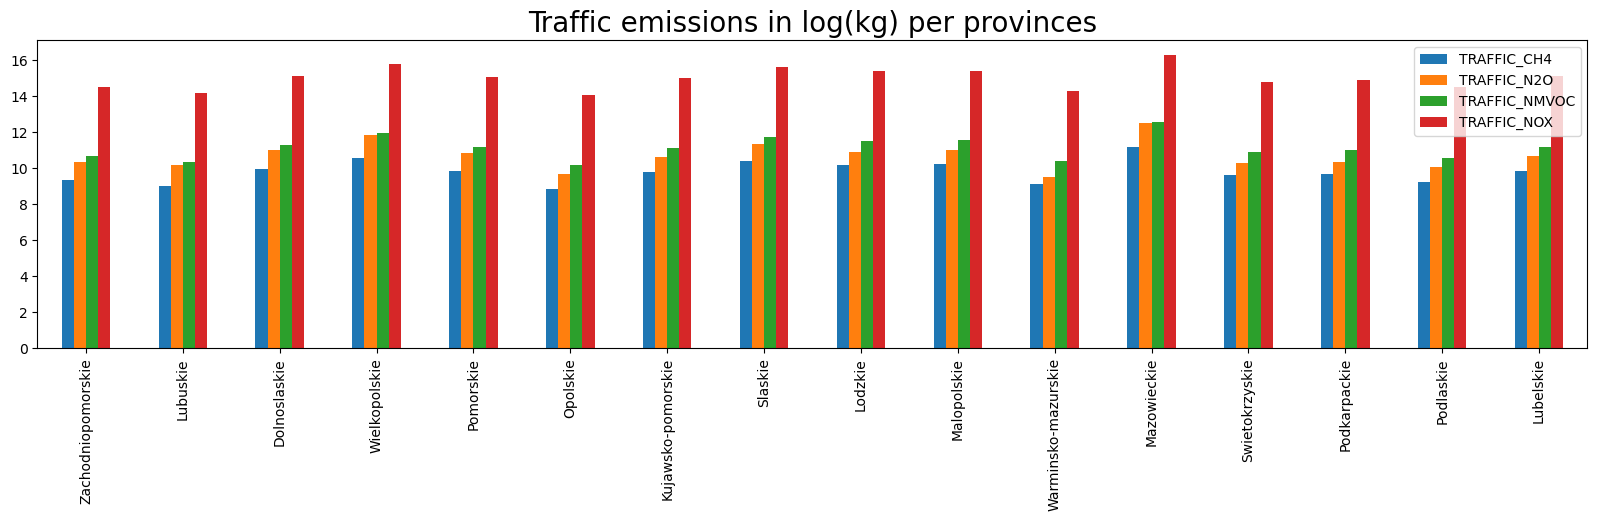

In [437]:
ax = np.log(A).plot.bar(figsize = (20,4), rot=90)
ax.set_title('Traffic emissions in log(kg) per provinces')
ax.title.set_size(20)

---

# Air pollution dataset (target)

In [452]:
air_pollution = pd.read_csv("data/air_pollution_OpenAQ/openaq.csv", sep=";")

In [453]:
air_pollution

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
0,PL,Kościerzyna,"Kościerzyna, ul. Targowa","54.120694, 17.975861",BC,GIOS,µg/m³,0.21808,2023-06-15T01:00:00+02:00,Poland
1,PL,Białystok,"Białystok, ul. 42 Pułku Piechoty","53.144122, 23.216322",PM10,GIOS,µg/m³,27.00000,2023-06-15T01:00:00+02:00,Poland
2,PL,Krapkowice,"Krapkowice, ul. 3 Maja","50.486194, 17.97477",NO2,GIOS,µg/m³,15.21850,2023-06-15T01:00:00+02:00,Poland
3,PL,Rzeszów,"Rzeszów, ul. Rejtana","50.024241999999994, 22.010575",SO2,GIOS,µg/m³,1.41250,2023-06-15T01:00:00+02:00,Poland
4,PL,Przemyśl,"Przemyśl, ul. Grunwaldzka","49.784338999999996, 22.756238999999997",PM10,GIOS,µg/m³,12.54280,2023-06-15T01:00:00+02:00,Poland
...,...,...,...,...,...,...,...,...,...,...
757,PL,Żory,"Żory, Os. Gen. Władysława Sikorskiego","50.029416, 18.689527",CO,GIOS,µg/m³,369.90000,2023-06-15T01:00:00+02:00,Poland
758,PL,Tarnów,"Tarnów, ul. Ks. Romana Sitko","50.018253, 20.992578",NO2,GIOS,µg/m³,8.04212,2023-06-15T01:00:00+02:00,Poland
759,PL,Biała Podlaska,"Biała Podlaska, ul. Orzechowa","52.029194, 23.149389",PM10,GIOS,µg/m³,16.00000,2023-06-15T01:00:00+02:00,Poland
760,PL,Warszawa,"Warszawa, ul. Tołstoja","52.285073, 20.933018",PM2.5,GIOS,µg/m³,21.04000,2023-06-14T22:00:00+02:00,Poland


air pollution unit = µg/m³ (concentration in a volume)\
emissions unit = kg (emission in one year)

In [490]:
n2o_air_pollution = air_pollution[air_pollution["Pollutant"]=="NO2"].reset_index(drop=True)

In [491]:
n2o_air_pollution

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
0,PL,Krapkowice,"Krapkowice, ul. 3 Maja","50.486194, 17.97477",NO2,GIOS,µg/m³,15.21850,2023-06-15T01:00:00+02:00,Poland
1,PL,Ostróda,"Ostróda, ul. Piłsudskiego","53.694587000000006, 19.969041",NO2,GIOS,µg/m³,8.57426,2023-06-15T01:00:00+02:00,Poland
2,PL,Piastów,"Piastów, ul. Pułaskiego","52.191728, 20.837489",NO2,GIOS,µg/m³,32.70000,2023-06-15T01:00:00+02:00,Poland
3,PL,Parzniewice,"Parzniewice, Ujęcie Wody","51.291175, 19.517556",NO2,GIOS,µg/m³,13.20000,2023-06-15T01:00:00+02:00,Poland
4,PL,Trzebinia,"Trzebinia, os. Związku Walki Młodych","50.159406, 19.477464",NO2,GIOS,µg/m³,4.55118,2023-06-15T01:00:00+02:00,Poland
...,...,...,...,...,...,...,...,...,...,...
140,PL,Kutno,"Kutno, ul. 1 Maja","52.231908, 19.353689",NO2,GIOS,µg/m³,11.90000,2023-06-15T01:00:00+02:00,Poland
141,PL,Koziegłowy,"Koziegłowy, os.Leśne","52.44933100000001, 16.999683",NO2,GIOS,µg/m³,5.36488,2023-06-15T01:00:00+02:00,Poland
142,PL,Diabla Góra,"Diabla Góra, Puszcza Borecka","54.124819, 22.038056",NO2,GIOS,µg/m³,3.53911,2023-06-15T01:00:00+02:00,Poland
143,PL,Inowrocław,"Inowrocław, ul. Solankowa","52.793122000000004, 18.241044",NO2,GIOS,µg/m³,10.00000,2023-06-15T01:00:00+02:00,Poland


In [492]:
def format_coordinates(df):
    for i in range(len(df)):
        coordinates = df["Coordinates"][i]
        df.loc[i, "Y"], df.loc[i, "X"] = float(coordinates.split(", ")[0]), float(coordinates.split(", ")[1])
    return df

In [493]:
n2o_air_pollution = format_coordinates(n2o_air_pollution)

In [494]:
n2o_air_pollution.head(2)

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label,Y,X
0,PL,Krapkowice,"Krapkowice, ul. 3 Maja","50.486194, 17.97477",NO2,GIOS,µg/m³,15.21850,2023-06-15T01:00:00+02:00,Poland,50.486194,17.974770
1,PL,Ostróda,"Ostróda, ul. Piłsudskiego","53.694587000000006, 19.969041",NO2,GIOS,µg/m³,8.57426,2023-06-15T01:00:00+02:00,Poland,53.694587,19.969041


In [495]:
n2o_air_pollution = gpd.GeoDataFrame(
    n2o_air_pollution, geometry=gpd.points_from_xy(n2o_air_pollution.X, n2o_air_pollution.Y), crs="EPSG:4326")


C:\Users\hudso\AppData\Local\Temp\ipykernel_5672\2879457585.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  provinces["CENTER"] = provinces["geometry"].centroid


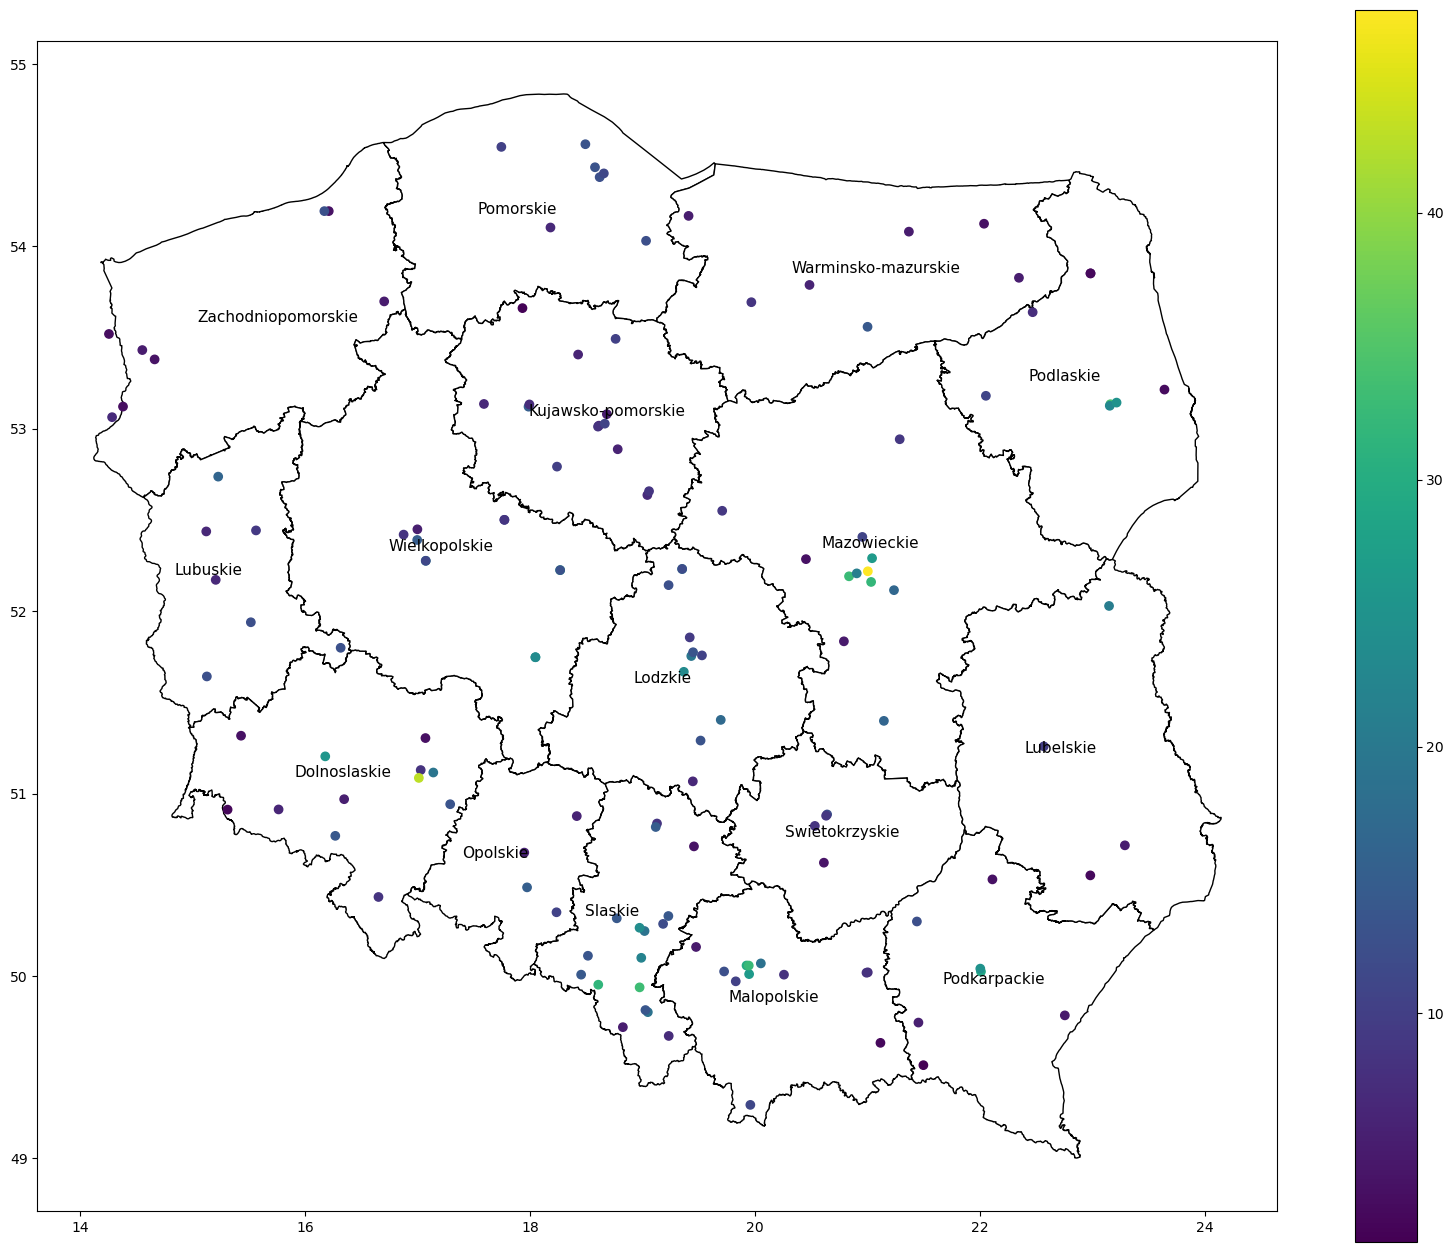

Text(0.5, 1.0, 'Provinces of Poland')

In [496]:
p = provinces.plot(color="white", edgecolor="black", figsize = (20,16))

# Some hassle to add annotation to the map (found solution via Google)
provinces["CENTER"] = provinces["geometry"].centroid
provinces_points = provinces.copy()
provinces_points.set_geometry(provinces["CENTER"], inplace = True)
texts = []

for x, y, label in zip(provinces_points.geometry.x, provinces_points.geometry.y, provinces_points["NAME"]):
    texts.append(plt.text(x-0.5, y, label, fontsize = 11))
    
n2o_air_pollution.plot(column='Value', ax=p, figsize = (20,16), legend=True)
plt.show()

p.axis('off')
p.set_title('Provinces of Poland')

---

# Interpolation (Kriging)

In [448]:
!pip install pykrige

   ---------------------------------------- 0.0/183.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/183.9 kB ? eta -:--:--
   --------------- ----------------------- 71.7/183.9 kB 787.7 kB/s eta 0:00:01
   ---------------------------------------- 183.9/183.9 kB 1.6 MB/s eta 0:00:00


In [449]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [499]:
x = n2o_air_pollution["X"]
y = n2o_air_pollution["Y"]
z = n2o_air_pollution["Value"]

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 14.414166183948995
Full Sill: 84.86759715055364
Range: 8.905256766682433
Nugget: 70.45343096660464 



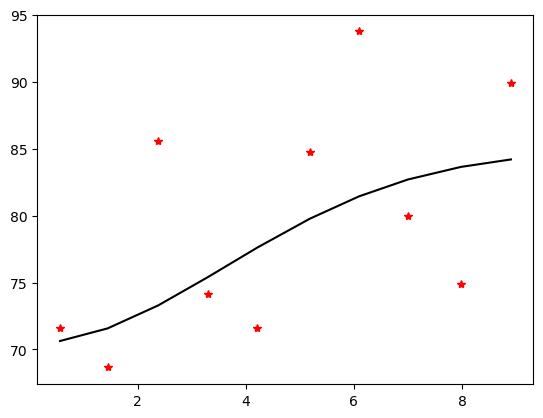

Calculating statistics on variogram model fit...


In [500]:
OK = OrdinaryKriging(
    x, 
    y, 
    z, 
    variogram_model='gaussian',
    verbose=True,
    enable_plotting=True,
    nlags=10,
)

In [501]:
OK.variogram_model_parameters

array([14.41416618,  8.90525677, 70.45343097])

In [502]:
provinces.total_bounds

array([14.12288486, 49.00204323, 24.14578308, 54.83641667])

In [510]:
extent_y = provinces.total_bounds[1], provinces.total_bounds[3]
extent_x = provinces.total_bounds[0], provinces.total_bounds[2]

In [523]:
gridx = np.arange(extent_x[0], extent_x[1], 0.01, dtype='float64')
gridy = np.arange(extent_y[0], extent_y[1], 0.01, dtype='float64')
zstar, ss = OK.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



In [524]:
print(zstar.shape)
print(ss.shape)

(584, 1003)
(584, 1003)


Text(0.5, 1.0, 'N2O concentration - interpolation (kriging)')

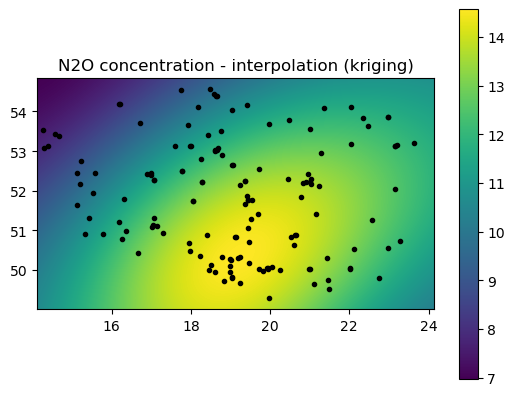

In [525]:
cax = plt.imshow(zstar, extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]), origin='lower')
plt.scatter(x, y, c='k', marker='.')
cbar=plt.colorbar(cax)
plt.title('N2O concentration - interpolation (kriging)')

Text(0.5, 1.0, 'N2O concentration standard devation')

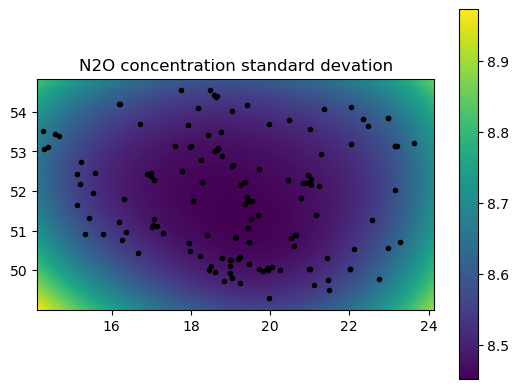

In [528]:
cax = plt.imshow(np.sqrt(ss), extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]), origin='lower')#, vmin = 0)
plt.scatter(x, y, c='k', marker='.')
cbar=plt.colorbar(cax)
plt.title('N2O concentration standard devation')

In [582]:
# nlines = 30
# ncolumns = 30


In [583]:
extent_y, extent_x

((49.0020432310084, 54.83641666701998),
 (14.122884859840275, 24.145783075311037))

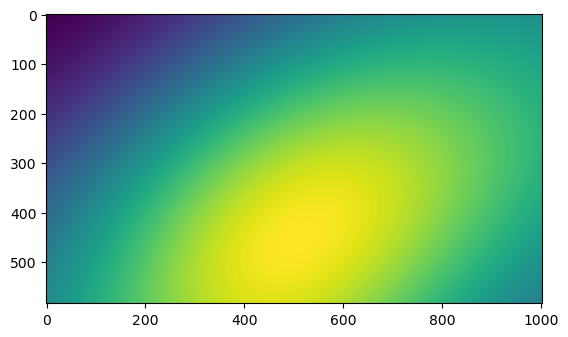

In [685]:
plt.imshow(np.flip(zstar, axis=0))

In [689]:
zstar_flip = np.flip(zstar, axis=0)

In [691]:
data = zstar_flip

In [692]:
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [14.122884859840275, 49.0020432310084, 24.145783075311037, 54.83641666701998] # South America
 
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = data.shape[0]
ncols = data.shape[1]
nbands = len(data.shape)
#data_type = gdal.GDT_Int16 # gdal.GDT_Float32
data_type = gdal.GDT_Float32

# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)#, options)

# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(data)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = 'my_test_data.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  

# Close the file
driver = None
grid_data = None

# Delete the temp grid
import os                
os.remove('grid_data')


Generated GeoTIFF: my_test_data.tif


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'grid_data'

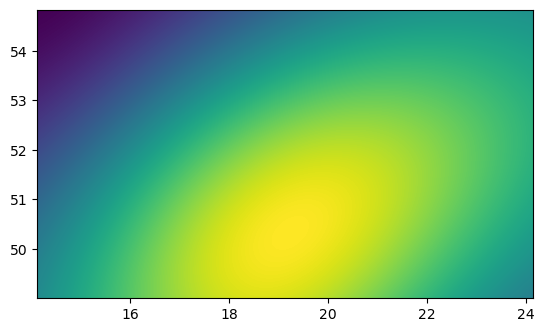

<Axes: >

In [693]:
import rasterio
from rasterio.plot import show
fp = r'my_test_data.tif'
img = rasterio.open(fp)
show(img)

In [694]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import matplotlib.pyplot as plt

In [544]:
df

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,ID_BUFOR_1,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,RODZAJ,geometry
0,None,PAN,31267966,0,POLSKA,None,0,20221206,0,20120612,...,0,1366371,0,None,0,0,42.7411921847,42.4412743442,panstwo,"POLYGON ((759237.270 141835.550, 759192.490 14..."


In [695]:
df = gpd.read_file('data/polska/polska.shp')
df  = df.to_crs({'init': 'epsg:4326'})

C:\Users\hudso\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


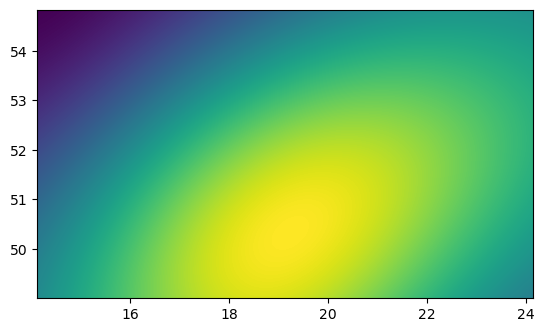

<Axes: >

In [696]:
fp = r'my_test_data.tif'
img = rasterio.open(fp)
show(img)

In [662]:
# # To Change the CRS
# df = gpd.read_file("data/polska/polska.shp").to_crs(4326)
# df.to_file("polska4326.shp")

In [699]:
import fiona
import rasterio
import rasterio.mask

with fiona.open("polska4326.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
     
with rasterio.open("my_test_data.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta    
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("RGB.byte.masked2.tif", "w", **out_meta) as dest:
    dest.write(out_image)    

saving zstar as raster

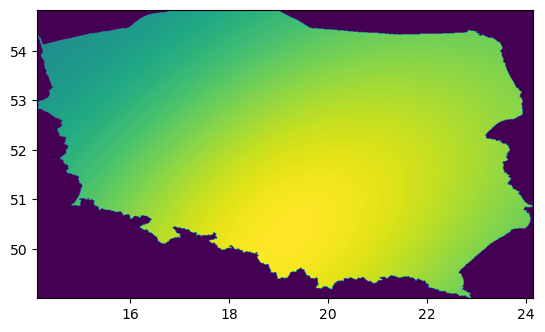

<Axes: >

In [700]:
fp = 'RGB.byte.masked2.tif'
img = rasterio.open(fp)
show(img)

<Axes: >

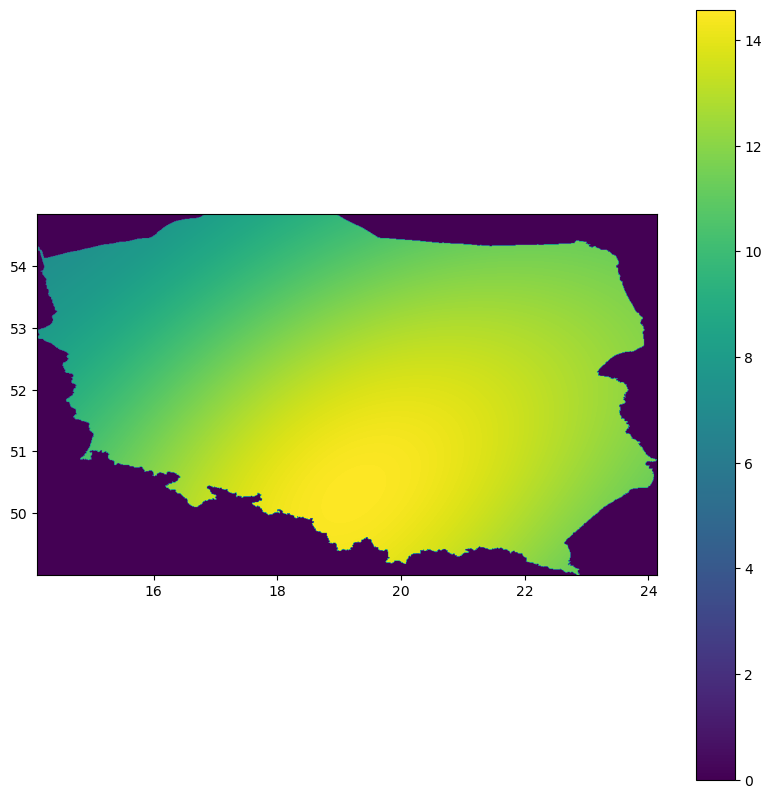

In [701]:
fig, ax = plt.subplots(figsize=(10,10))
image_hidden = ax.imshow(img.read()[0])
fig.colorbar(image_hidden, ax=ax)
rasterio.plot.show(img, ax=ax)

In [ ]:
# confere no qgis esse mapa ai. está muito suavizado... pode estar certo, mas melhor conferir lá tb.
# daí o proximo passo é tirar a média por provincias e incluir no dataframe.
# finaliza com o feature importance.

---

# Feature importance analysis

In [438]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [443]:
sector_province_nox.head(2)

,NAME,geometry,CENTER,CHEMICAL_NOx,ENERGY_NOx,FOOD_BEVERAGE_NOx,LIVESTOCK_NOx,METALS_NOx,MINERAL_NOx,OTHER_NOx,PAPER_WOOD_NOx,WASTE_NOx,TRAFFIC_NOX
0,Zachodniopomorskie,"POLYGON ((14.24969 53.92403, 14.27264 53.92417...",POINT (15.54285 53.58506),0.0,4021000.0,0.0,0.0,0.0,0.0,0.0,801000.0,161000.0,2.030799e+06
1,Lubuskie,"POLYGON ((15.38223 51.51179, 15.38185 51.51153...",POINT (15.34275 52.19617),653000.0,478000.0,0.0,0.0,0.0,143000.0,0.0,636000.0,320000.0,1.410837e+06


In [444]:
sector_province_nox.columns

Index(['NAME', 'geometry', 'CENTER', 'CHEMICAL_NOx', 'ENERGY_NOx',
       'FOOD_BEVERAGE_NOx', 'LIVESTOCK_NOx', 'METALS_NOx', 'MINERAL_NOx',
       'OTHER_NOx', 'PAPER_WOOD_NOx', 'WASTE_NOx', 'TRAFFIC_NOX'],
      dtype='object')

In [445]:
df_nox = sector_province_nox[['CHEMICAL_NOx', 'ENERGY_NOx',
       'FOOD_BEVERAGE_NOx', 'LIVESTOCK_NOx', 'METALS_NOx', 'MINERAL_NOx',
       'OTHER_NOx', 'PAPER_WOOD_NOx', 'WASTE_NOx', 'TRAFFIC_NOX']]

In [446]:
df_nox = pd.DataFrame(StandardScaler().fit_transform(df_nox))

In [447]:
df_nox

,0,1,2,3,4,5,6,7,8,9
0,-0.561443,-0.448587,-0.377960,0.0,-0.355375,-0.886088,0.0,2.738589,-0.636105,-0.720894
1,0.593046,-0.941952,-0.377960,0.0,-0.355375,-0.782333,0.0,2.024175,-0.416443,-0.958502
2,-0.561443,0.442756,2.631249,0.0,-0.179039,-0.702521,0.0,-0.729569,-0.858530,-0.095534
3,0.430392,0.201713,-0.377960,0.0,0.661951,-0.033557,0.0,-0.729569,-0.858530,1.195233
4,-0.561443,-0.678768,-0.377960,0.0,-0.355375,-0.812806,0.0,-0.287931,0.619699,-0.182454
5,-0.280335,0.156596,-0.377960,0.0,-0.355375,1.845638,0.0,-0.729569,0.115443,-1.008120
6,1.206534,-0.620979,-0.377960,0.0,-0.355375,0.312534,0.0,0.132058,1.990170,-0.217110
7,-0.561443,1.362228,-0.377960,0.0,3.751232,0.541085,0.0,-0.209995,2.346602,0.790611
8,-0.561443,2.649600,-0.377960,0.0,-0.355375,1.042445,0.0,0.140718,-0.510386,0.335173
9,-0.561443,0.058703,-0.377960,0.0,-0.073067,-0.273717,0.0,-0.729569,0.701209,0.388297
